In [1]:
# Import all required libraries
import pandas as pd
import numpy as np
import pingouin as pg
from pathlib import Path
from scipy import stats
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import os.path as op
import re
import nibabel as nib

# Additional imports for neuroimaging and atlas processing
from nilearn import datasets, masking, input_data, plotting
from nilearn.connectome import ConnectivityMeasure
from nilearn.reporting import get_clusters_table
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


/var/folders/w7/tr80j6dx7kz1xqvddnxtqtzr0000gn/T/ipykernel_10132/2353156154.py:15: DeprecationWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  from nilearn import datasets, masking, input_data, plotting


In [2]:
# Setup directories and plotting theme
RELI_DIR = Path("dset/derivatives/caps/interrater")
FIGURES_DIR = Path("dset/derivatives/figures")
# will use loop later to run over all subjects
OUT_DIR = Path("dset/derivatives/caps")
KMEANS_DIR = OUT_DIR / "kmeans"
KMEANS_DIR.mkdir(parents=True, exist_ok=True)
MASK_DIR = OUT_DIR / "caps_masks"
MASK_DIR.mkdir(parents=True, exist_ok=True)


Loading Craddock atlas from local file...
Atlas loaded: dset/craddock2012_tcorr05_2level_270_2mm.nii
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 1

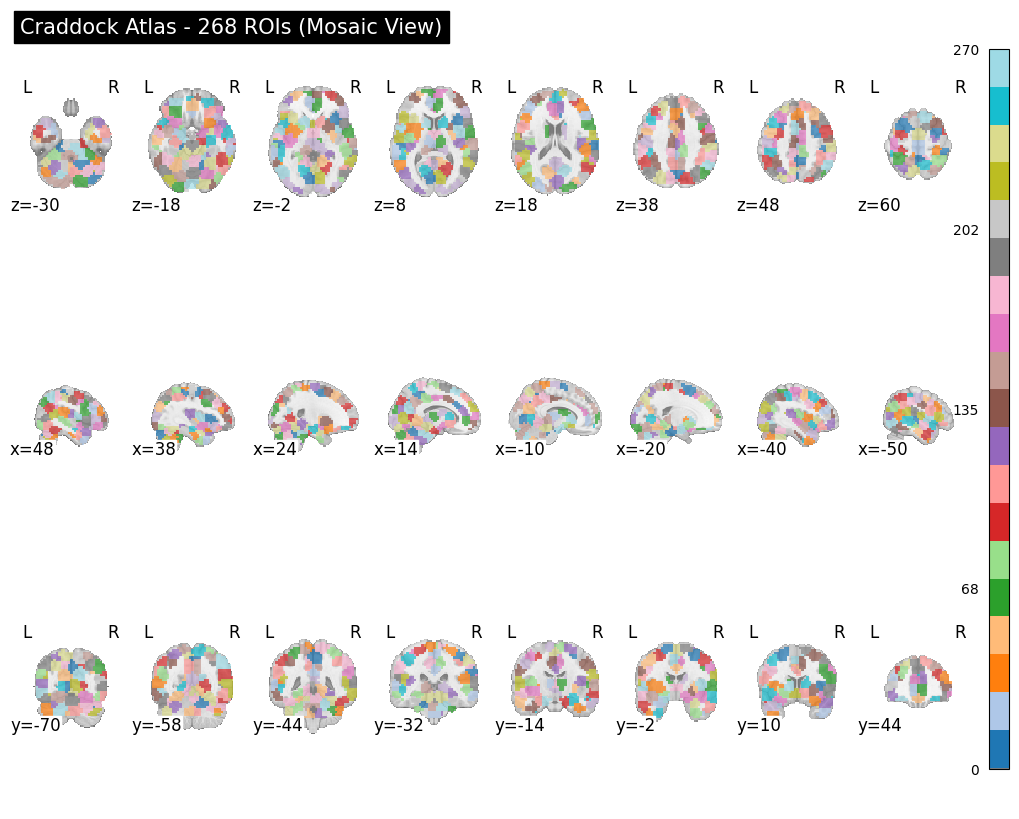


Plotting regions (atlas value 269)...


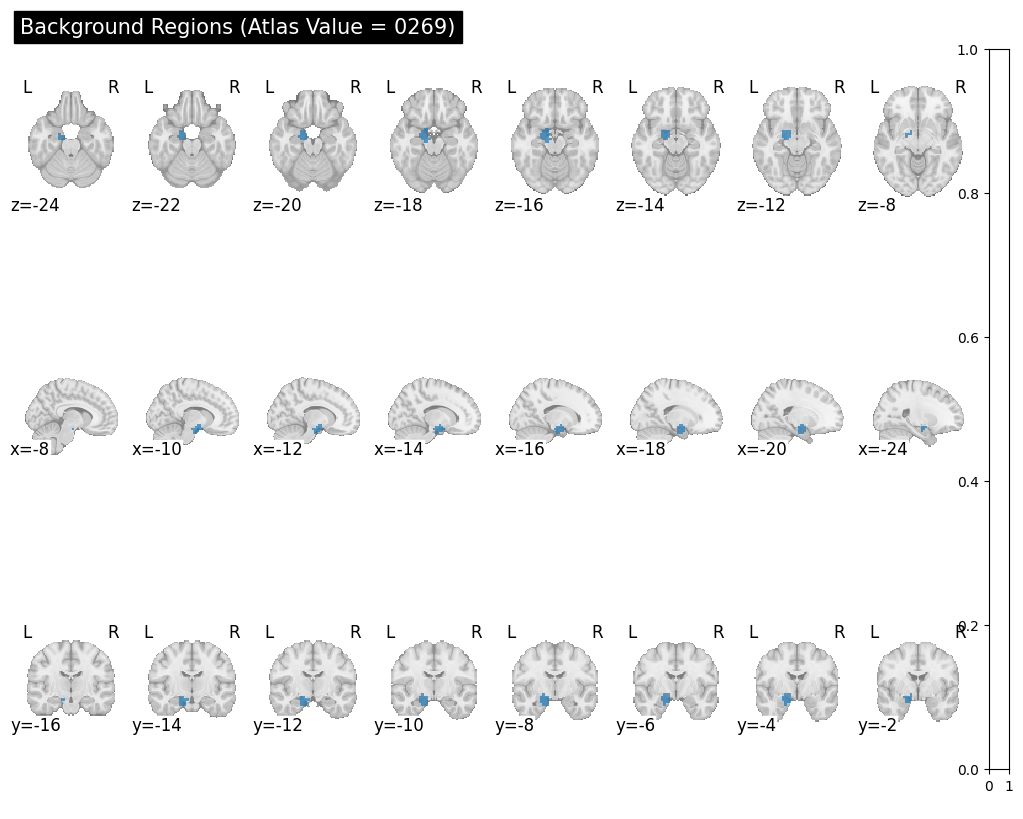

Background Statistics:
• Background voxels: 755,557
• Total voxels: 902,629
• Background coverage: 83.7%
Atlas Statistics:
• Total ROIs: 268
• Label range: 1 - 270
• Brain voxels: 147,072
• Mean ROI size: 548.8 voxels
• Std ROI size: 106.6 voxels
• Min ROI size: 216 voxels
• Max ROI size: 848 voxels
• Atlas coverage: 16.3%


In [3]:
# Load Craddock atlas from local file
print("Loading Craddock atlas from local file...")

# Path to the unzipped atlas file
atlas_filename = Path("dset/craddock2012_tcorr05_2level_270_2mm.nii")

print(f"Atlas loaded: {atlas_filename}")

# Load the atlas to check its properties
atlas_img = nib.load(atlas_filename)
atlas_data = atlas_img.get_fdata()

# Get unique ROI labels (excluding background/0)
unique_labels = np.unique(atlas_data)
print(unique_labels)
unique_labels = unique_labels[unique_labels != 0]  # Remove background
n_rois = len(unique_labels)

print(f"Atlas shape: {atlas_data.shape}")
print(f"Number of ROIs: {n_rois}")
print(f"ROI labels range: {unique_labels.min()} to {unique_labels.max()}")


print(f"\nPlotting Craddock atlas...")

# Create figure
fig = plt.figure(figsize=(10, 8))

# Plot Mosaic view only
display = plotting.plot_roi(
    atlas_img,
    title=f'Craddock Atlas - {n_rois} ROIs (Mosaic View)',
    display_mode='mosaic',
    cut_coords=8,
    colorbar=True,
    cmap='tab20',
    figure=fig
)

plt.show()

# Plot  regions (atlas value 269)
print(f"\nPlotting regions (atlas value 269)...")

# Create a binary mask for background regions (value = 269)
background_data = np.where(atlas_data == 270, 1, 0)
background_img = nib.Nifti1Image(background_data, atlas_img.affine, atlas_img.header)

# Create figure for background
fig = plt.figure(figsize=(10, 8))

# Plot background regions
display = plotting.plot_roi(
    background_img,
    title='Background Regions (Atlas Value = 0269)',
    display_mode='mosaic',
    cut_coords=8,
    colorbar=True,
    cmap='tab20',
    figure=fig
)

plt.show()

# Background statistics
background_voxels = np.sum(atlas_data == 0)
total_voxels = np.prod(atlas_data.shape)
background_percentage = (background_voxels / total_voxels) * 100

print(f"Background Statistics:")
print(f"• Background voxels: {background_voxels:,}")
print(f"• Total voxels: {total_voxels:,}")
print(f"• Background coverage: {background_percentage:.1f}%")

# Create a detailed summary 
roi_sizes = []
for label in unique_labels:
    roi_size = np.sum(atlas_data == label)
    roi_sizes.append(roi_size)
brain_mask = atlas_data > 0
total_brain_voxels = np.sum(brain_mask)
atlas_coverage = (np.sum(atlas_data > 0) / np.prod(atlas_data.shape)) * 100


# Summary statistics
stats_text = f"""Atlas Statistics:
• Total ROIs: {n_rois}
• Label range: {unique_labels.min():.0f} - {unique_labels.max():.0f}
• Brain voxels: {total_brain_voxels:,}
• Mean ROI size: {np.mean(roi_sizes):.1f} voxels
• Std ROI size: {np.std(roi_sizes):.1f} voxels
• Min ROI size: {np.min(roi_sizes)} voxels
• Max ROI size: {np.max(roi_sizes)} voxels
• Atlas coverage: {atlas_coverage:.1f}%"""

print(stats_text)


In [4]:
# Create masker for extracting time series from ROIs
masker = input_data.NiftiLabelsMasker(
    labels_img=atlas_img,
    standardize=True,  #z-scores the time series
    memory='nilearn_cache',
    mask_type="whole-brain",
    verbose=1
)

In [5]:
# Define all runs for each participant and episode
participant_data = {
    "sub-Blossom": {
        "S01E01": [1, 2, 3],           # Episode 1 has 3 runs
        "S01E02": [1, 2, 3, 4, 5, 6, 7], # Episode 2 has 7 runs
    },
    "sub-Bubbles": {
        "S01E01": [1, 2, 3],
        "S01E02": [1, 2, 3, 4, 5, 6, 7],
        "S01E03": [1, 2, 3, 4, 5, 6],     # Add other participants as needed
        "S01E04": [1, 2, 3, 4, 5]
    },
    "sub-Buttercup": {
        "S01E01": [1, 2, 3],
        "S01E02": [1, 2, 3, 4, 5, 6, 7],
        "S01E03": [1, 2, 3, 4, 5, 6],
        "S01E04": [1, 2, 3, 4, 5]
}
}

In [6]:
# Extract BOLD time series and create z-scored participant matrices

# Initialize storage for participant-level matrices
all_participant_matrices = {}

for sub_id, episodes in participant_data.items():
    print(f"\n{'='*60}")
    print(f"PROCESSING {sub_id}")
    print(f"{'='*60}")
    
    # Check if output files already exist
    output_file = KMEANS_DIR / f"{sub_id}_zscore_strangerthings_matrix.npy"
    output_csv = KMEANS_DIR / f"{sub_id}_zscore_strangerthings_matrix.csv"
    
    if output_file.exists() and output_csv.exists():
        print(f"Output files already exist for {sub_id}, skipping processing:")
        print(f"  - {output_file}")
        print(f"  - {output_csv}")
        
        # Load existing matrix for consistency
        participant_matrix = np.load(output_file)
        all_participant_matrices[sub_id] = participant_matrix
        print(f"Loaded existing matrix: {participant_matrix.shape}")
        continue
    
    participant_timeseries = []
    
    for episode_key, run_numbers in episodes.items():
        ep_num = int(episode_key.split('_')[1])
        
        print(f"\nProcessing Episode {ep_num} with {len(run_numbers)} runs...")
        
        for run_num in run_numbers:
            print(f"  Processing run {run_num}...")
            
            TASK_DIR = Path(f"dset/{sub_id}/ses-{ep_num:02d}/func") 
            
            # Construct the filename - note that run number is NOT zero-padded
            task_filename = f"{sub_id}_ses-{ep_num:02d}_task-strangerthings_run-{run_num}_part-mag_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz"
            task_filepath = TASK_DIR / task_filename


            # Extract time series from 268 ROIs
            print(f"    Extracting time series from {task_filepath.name}...")
            time_series = masker.fit_transform(task_filepath)
                
            print(f"    Time series shape: {time_series.shape} (TRs x ROIs)")
                
            # Store z-scored time series for this run
            participant_timeseries.append(time_series)
                

    if participant_timeseries:
        # Concatenate all runs for this participant
        print(f"\nConcatenating {len(participant_timeseries)} runs for {sub_id}...")
        participant_matrix = np.vstack(participant_timeseries)
        
        print(f"Final participant matrix shape: {participant_matrix.shape}")
        print(f"  - Total TRs across all runs: {participant_matrix.shape[0]}")
        print(f"  - Number of ROIs (Craddock): {participant_matrix.shape[1]}")
        
        # Store the participant-level matrix
        all_participant_matrices[sub_id] = participant_matrix
        
        # Save the participant matrix   
        np.save(output_file, participant_matrix)
        print(f"Saved participant matrix to: {output_file}")
        
        # Also save as CSV for easier inspection
        df_matrix = pd.DataFrame(participant_matrix, 
                                columns=[f"{unique_labels[i]}" for i in range(participant_matrix.shape[1])])
        df_matrix.to_csv(output_csv, index=False)
        print(f"Saved participant matrix (CSV) to: {output_csv}")
        


print(f"\n{'='*60}")
print("PROCESSING COMPLETE")
print(f"{'='*60}")
print(f"Processed {len(all_participant_matrices)} participants:")
for sub_id, matrix in all_participant_matrices.items():
    print(f"  {sub_id}: {matrix.shape[0]} TRs × {matrix.shape[1]} ROIs")


PROCESSING sub-Blossom
Output files already exist for sub-Blossom, skipping processing:
  - dset/derivatives/caps/kmeans/sub-Blossom_zscore_strangerthings_matrix.npy
  - dset/derivatives/caps/kmeans/sub-Blossom_zscore_strangerthings_matrix.csv
Loaded existing matrix: (3021, 268)

PROCESSING sub-Bubbles
Output files already exist for sub-Bubbles, skipping processing:
  - dset/derivatives/caps/kmeans/sub-Bubbles_zscore_strangerthings_matrix.npy
  - dset/derivatives/caps/kmeans/sub-Bubbles_zscore_strangerthings_matrix.csv
Loaded existing matrix: (6551, 268)

PROCESSING sub-Buttercup
Output files already exist for sub-Buttercup, skipping processing:
  - dset/derivatives/caps/kmeans/sub-Buttercup_zscore_strangerthings_matrix.npy
  - dset/derivatives/caps/kmeans/sub-Buttercup_zscore_strangerthings_matrix.csv
Loaded existing matrix: (6477, 268)

PROCESSING COMPLETE
Processed 3 participants:
  sub-Blossom: 3021 TRs × 268 ROIs
  sub-Bubbles: 6551 TRs × 268 ROIs
  sub-Buttercup: 6477 TRs × 268 

In [7]:
# Load saved time series matrices and perform k-means clustering

for sub_id, episodes in participant_data.items():
    print(f"\n{'='*60}")
    print(f"PROCESSING {sub_id}")
    print(f"{'='*60}")
    
    # Check if clustering outputs already exist
    labels_csv_file = KMEANS_DIR / f"{sub_id}_cluster_labels.csv"
    centers_csv_file = KMEANS_DIR / f"{sub_id}_cluster_centers.csv"
    metadata_file = KMEANS_DIR / f"{sub_id}_clustering_metadata.txt"
    elbow_plot_file = FIGURES_DIR / f"{sub_id}_elbow_silhouette_analysis.png"
    
    if (labels_csv_file.exists() and centers_csv_file.exists() and 
        metadata_file.exists() and elbow_plot_file.exists()):
        print(f"Clustering outputs already exist for {sub_id}, skipping processing:")
        print(f"  - {labels_csv_file}")
        print(f"  - {centers_csv_file}")
        print(f"  - {metadata_file}")
        print(f"  - {elbow_plot_file}")
        continue
    
    timeseries_file = KMEANS_DIR / f"{sub_id}_zscore_strangerthings_matrix.npy"
    
    if timeseries_file.exists():
        # Load the participant time series matrix
        participant_matrix = np.load(timeseries_file)
        print(f"Loaded time series matrix: {participant_matrix.shape}")
        print(f"  - Time points (TRs): {participant_matrix.shape[0]}")
        print(f"  - ROIs: {participant_matrix.shape[1]}")
        
        # Determine optimal number of clusters using elbow method and silhouette score
        print("\nDetermining optimal number of clusters...")
        k_range = range(2, 21)  # Test 2 to 20 clusters
        inertias = []
        silhouette_scores = []
        
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            cluster_labels = kmeans.fit_predict(participant_matrix)
            
            inertias.append(kmeans.inertia_)
            sil_score = silhouette_score(participant_matrix, cluster_labels)
            silhouette_scores.append(sil_score)
            
            print(f"  k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={sil_score:.3f}")
        
        # Plot elbow curve and silhouette scores
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Elbow plot
        ax1.plot(k_range, inertias, 'bo-')
        ax1.set_xlabel('Number of Clusters (k)')
        ax1.set_ylabel('Inertia')
        ax1.set_title(f'{sub_id} - Elbow Method for Optimal k')
        ax1.grid(True, alpha=0.3)
        
        # Silhouette score plot
        ax2.plot(k_range, silhouette_scores, 'ro-')
        ax2.set_xlabel('Number of Clusters (k)')
        ax2.set_ylabel('Silhouette Score')
        ax2.set_title(f'{sub_id} - Silhouette Score vs Number of Clusters')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        # Save the plot
        fig.savefig(elbow_plot_file, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Saved elbow/silhouette plot: {elbow_plot_file}")
        
        plt.show()
        
        # Find optimal k based on elbow method
        # Calculate the rate of change (differences) in inertia
        inertia_diffs = np.diff(inertias)
        
        # Calculate the second derivative (rate of change of the rate of change)
        second_diffs = np.diff(inertia_diffs)
        
        # Find the elbow point - where the second derivative is maximum
        # (greatest change in the rate of decrease)
        elbow_idx = np.argmax(second_diffs) + 2  # +2 because we lost 2 points in double diff
        optimal_k = k_range[elbow_idx]
        
        # Also report the silhouette score for this k
        corresponding_silhouette = silhouette_scores[elbow_idx]
        
        print(f"\nElbow method results:")
        print(f"  - Optimal number of clusters (elbow): {optimal_k}")
        print(f"  - Silhouette score at elbow k: {corresponding_silhouette:.3f}")
        print(f"  - Inertia at elbow k: {inertias[elbow_idx]:.2f}")
        
        # For comparison, also show the k with best silhouette score
        best_sil_k = k_range[np.argmax(silhouette_scores)]
        max_silhouette = max(silhouette_scores)
        print(f"\nFor comparison:")
        print(f"  - Best silhouette k: {best_sil_k}")
        print(f"  - Best silhouette score: {max_silhouette:.3f}")
        
        print(f"\nOptimal number of clusters: {optimal_k}")
        print(f"Silhouette score at optimal k: {corresponding_silhouette:.3f}")
        
        # Perform final clustering with optimal k (from elbow method)
        print(f"\nPerforming final k-means clustering with k={optimal_k} (elbow method)...")
        final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
        final_labels = final_kmeans.fit_predict(participant_matrix)
        
        # Get cluster information
        cluster_unique_labels, label_counts = np.unique(final_labels, return_counts=True)
        
        print(f"Clustering results:")
        print(f"  - Total time points: {len(final_labels)}")
        print(f"  - Number of clusters: {len(cluster_unique_labels)}")
        
        for i, (label, count) in enumerate(zip(cluster_unique_labels, label_counts)):
            percentage = (count / len(final_labels)) * 100
            print(f"  - CAP {label+1}: {count} time points ({percentage:.1f}%)")
        
        # Save clustering results
        df_labels = pd.DataFrame({
            'timepoint': range(len(final_labels)),
            'cluster_label': final_labels
        })
        df_labels.to_csv(labels_csv_file, index=False)
        print(f"Saved cluster labels (CSV) to: {labels_csv_file}")
        
        # Save cluster centers (CAPs) as CSV for easy inspection
        # Get the atlas unique_labels from the global scope (from cell 3)
        # This ensures we use the actual Craddock atlas numbers as column names
        from pathlib import Path
        atlas_filename = Path("dset/craddock2012_tcorr05_2level_270_2mm.nii")
        atlas_img_temp = nib.load(atlas_filename)
        atlas_data_temp = atlas_img_temp.get_fdata()
        atlas_unique_labels = np.unique(atlas_data_temp)
        atlas_unique_labels = atlas_unique_labels[atlas_unique_labels != 0]  # Remove background
        
        df_centers = pd.DataFrame(
            final_kmeans.cluster_centers_,
            columns=[f"{atlas_unique_labels[i]}" for i in range(final_kmeans.cluster_centers_.shape[1])],
            index=[f"CAP{i+1}" for i in range(final_kmeans.cluster_centers_.shape[0])]
        )
        df_centers.to_csv(centers_csv_file)
        print(f"Saved cluster centers (CSV) to: {centers_csv_file}")
        
        # Save clustering metadata
        metadata = {
            'n_clusters': optimal_k,
            'method': 'elbow',
            'silhouette_score': corresponding_silhouette,
            'inertia': final_kmeans.inertia_,
            'cluster_sizes': label_counts.tolist(),
            'total_timepoints': len(final_labels),
            'best_silhouette_k': best_sil_k,
            'max_silhouette_score': max_silhouette
        }
        
        with open(metadata_file, 'w') as f:
            for key, value in metadata.items():
                f.write(f"{key}: {value}\n")
        print(f"Saved clustering metadata to: {metadata_file}")
        
        # Store results for further analysis
        globals()[f"{sub_id}_cluster_labels"] = final_labels
        globals()[f"{sub_id}_cluster_centers"] = final_kmeans.cluster_centers_
        globals()[f"{sub_id}_kmeans_model"] = final_kmeans
        
    else:
        print(f"ERROR: Time series file not found: {timeseries_file}")

print(f"\n{'='*60}")
print("CLUSTERING COMPLETE")
print(f"{'='*60}")


PROCESSING sub-Blossom
Clustering outputs already exist for sub-Blossom, skipping processing:
  - dset/derivatives/caps/kmeans/sub-Blossom_cluster_labels.csv
  - dset/derivatives/caps/kmeans/sub-Blossom_cluster_centers.csv
  - dset/derivatives/caps/kmeans/sub-Blossom_clustering_metadata.txt
  - dset/derivatives/figures/sub-Blossom_elbow_silhouette_analysis.png

PROCESSING sub-Bubbles
Clustering outputs already exist for sub-Bubbles, skipping processing:
  - dset/derivatives/caps/kmeans/sub-Bubbles_cluster_labels.csv
  - dset/derivatives/caps/kmeans/sub-Bubbles_cluster_centers.csv
  - dset/derivatives/caps/kmeans/sub-Bubbles_clustering_metadata.txt
  - dset/derivatives/figures/sub-Bubbles_elbow_silhouette_analysis.png

PROCESSING sub-Buttercup
Clustering outputs already exist for sub-Buttercup, skipping processing:
  - dset/derivatives/caps/kmeans/sub-Buttercup_cluster_labels.csv
  - dset/derivatives/caps/kmeans/sub-Buttercup_cluster_centers.csv
  - dset/derivatives/caps/kmeans/sub-But

In [8]:
# # Create DataFrames for CAP visualization data and plot them

# masks_output_dir = OUT_DIR / "caps_masks"
# masks_output_dir.mkdir(parents=True, exist_ok=True)


# for sub_id, episodes in participant_data.items():
#     print(f"\n{'='*60}")
#     print(f"PREPARING VISUALIZATION DATA FOR {sub_id}")
#     print(f"{'='*60}")

#     centers_df = pd.read_csv(OUT_DIR / f"kmeans/{sub_id}_cluster_centers.csv")

#     # Loop over each CAP (row)
#     for i, cap in centers_df.iterrows():
#         cap_df = pd.DataFrame([cap], columns=centers_df.columns)
#         print(f"\nDataFrame for cap {i+1}:")
#         print(cap_df)

#         # --- Prepare CAP visualization ---
#         cap_name = cap_df.iloc[0, 0]  # e.g., 'CAP_0'
#         z_values = cap_df.iloc[0, 1:].astype(float).values
#         roi_labels = [float(c) for c in cap_df.columns[1:]]  # ROI labels (1.0, 2.0, ...)

#         atlas_data = np.asanyarray(atlas_img.dataobj)
#         mask_data = np.zeros_like(atlas_data, dtype=float)

#         # Map z-values to atlas regions
#         for roi, z in zip(roi_labels, z_values):
#             mask_data[atlas_data == int(roi)] = z

#         mask_img = nib.Nifti1Image(mask_data, atlas_img.affine, atlas_img.header)

#         mask_path = masks_output_dir / f"{sub_id}_{cap_name}.nii.gz"
#         #nib.save(mask_img, mask_path)
#         #print(f"Saved NIfTI: {mask_path}")

#         # --- Plot CAP on Craddock atlas ---
#         fig = plt.figure(figsize=(10, 8))
#         vmin, vmax = np.nanmin(z_values), np.nanmax(z_values)
#         vabs = max(abs(vmin), abs(vmax))

#         display = plotting.plot_stat_map(
#             mask_img,
#             title=f"{sub_id} - {cap_name}",
#             display_mode="mosaic",
#             cut_coords=8,
#             cmap="Spectral",
#             colorbar=True,
#             vmin=-vabs,
#             vmax=vabs,
#             figure=fig
#         )

#         plt.show()

In [9]:
# PCT_OF_MAX = 15.0  # keep |z| >= (PCT_OF_MAX/100) * max|z| per CAP

# for sub_id, episodes in participant_data.items():
#     print(f"\n{'='*60}\nPREPARING VISUALIZATION DATA FOR {sub_id}\n{'='*60}")

#     centers_df = pd.read_csv(OUT_DIR / f"kmeans/{sub_id}_cluster_centers.csv")

#     for i, cap in centers_df.iterrows():
#         cap_df = pd.DataFrame([cap], columns=centers_df.columns)
#         cap_name = cap_df.iloc[0, 0]
#         roi_labels = [float(c) for c in cap_df.columns[1:]]
#         z_vals = cap_df.iloc[0, 1:].astype(float).values

#         # --- Two-tailed threshold (%) of this CAP's max |activation| ---
#         vabs_full = float(np.nanmax(np.abs(z_vals)))
#         thr = (PCT_OF_MAX / 100.0) * vabs_full

#         # --- Map raw parcel values to atlas, then enforce voxelwise threshold ---
#         atlas_data = np.asanyarray(atlas_img.dataobj)
#         mask_data = np.zeros_like(atlas_data, dtype=np.float32)
#         for roi, z in zip(roi_labels, z_vals):
#             if np.isfinite(z):
#                 mask_data[atlas_data == int(roi)] = z
#         mask_data[np.abs(mask_data) < thr] = 0.0  # hard two-sided threshold

#         # --- Save thresholded CAP with the SAME filename ---
#         mask_img = nib.Nifti1Image(mask_data, atlas_img.affine, atlas_img.header)
#         mask_path = masks_output_dir / f"{sub_id}_weighted-{int(PCT_OF_MAX)}_{cap_name}.nii.gz"
#         #nib.save(mask_img, mask_path)
#         #print(f"Saved thresholded NIfTI: {mask_path} (|z| ≥ {thr:.4f})")

#         # --- Plot full (symmetric) map for context ---
#         fig = plt.figure(figsize=(10, 8))
#         plotting.plot_stat_map(
#             mask_img,
#             title=f"{sub_id} - {cap_name} (≥{int(PCT_OF_MAX)}% max|z|; thr={thr:.2f})",
#             display_mode="mosaic",
#             cut_coords=8,
#             cmap="Spectral_r",
#             colorbar=True,
#             threshold=thr,         # draws threshold line on colorbar
#             symmetric_cbar=True,
#             vmin=-vabs_full,
#             vmax=vabs_full,
#             figure=fig
#         )
#         plt.show()

#         # --- Split into positive and negative parts (already thresholded) ---
#         pos_data = np.where(mask_data > 0, mask_data, 0.0)
#         neg_data = np.where(mask_data < 0, mask_data, 0.0)

#         pos_img = nib.Nifti1Image(pos_data, atlas_img.affine, atlas_img.header)
#         neg_img = nib.Nifti1Image(neg_data, atlas_img.affine, atlas_img.header)

#         # (Optional) save separate maps
#         # nib.save(pos_img, masks_output_dir / f"{sub_id}_weighted-{int(PCT_OF_MAX)}_{cap_name}_pos.nii.gz")
#         # nib.save(neg_img, masks_output_dir / f"{sub_id}_weighted-{int(PCT_OF_MAX)}_{cap_name}_neg.nii.gz")

#         # --- Plot positive only: colorbar from 0 to max(pos) ---
#         pos_vals = pos_data[pos_data > 0]
#         if pos_vals.size:
#             fig = plt.figure(figsize=(10, 8))
#             plotting.plot_stat_map(
#                 pos_img,
#                 title=f"{sub_id} - {cap_name} (pos ≥ {int(PCT_OF_MAX)}% max|z|; thr={thr:.2f})",
#                 display_mode="mosaic",
#                 cut_coords=8,
#                 cmap="Reds",
#                 colorbar=True,
#                 threshold=thr,                 # uses same thr
#                 vmin=0.0,                      # start at 0 (no 1e-6)
#                 vmax=float(np.max(pos_vals)),
#                 figure=fig
#             )
#             plt.show()
#         else:
#             print(f"No positive activations for {cap_name}")

#         # --- Plot negative only: colorbar from min(neg) to 0 ---
#         neg_vals = neg_data[neg_data < 0]
#         if neg_vals.size:
#             fig = plt.figure(figsize=(10, 8))

#             # KEEP thr POSITIVE for nilearn; use a separate var for display
#             thr_plot = float(thr)          # positive number
#             thr_label = -thr_plot          # shown in the title

#             plotting.plot_stat_map(
#                 neg_img,
#                 title=f"{sub_id} - {cap_name} (neg ≤ {int(-100*thr_label/vabs_full)}% max|z|; thr={thr_label:.2f})",
#                 display_mode="mosaic",
#                 cut_coords=8,
#                 cmap="Blues_r",
#                 colorbar=True,
#                 threshold=thr_plot,                 # must be non-negative
#                 vmin=float(np.min(neg_vals)),       # most negative value
#                 vmax=0.0,                           # end at 0
#                 symmetric_cbar=False,
#                 figure=fig
#             )
#             plt.show()
#         else:
#             print(f"No negative activations for {cap_name}")


PREPARING Z-SCORE NORMALIZED WEIGHTED MASKS FOR sub-Blossom
Saved z-score weighted NIfTI: dset/derivatives/caps/caps_masks/sub-Blossom_zscore-weighted-0_CAP_1.nii.gz
  Original range:    [-0.535, 0.485]
  Normalized (kept): [-1.000, 0.905]
Saved z-score weighted NIfTI: dset/derivatives/caps/caps_masks/sub-Blossom_zscore-weighted-0_CAP_1.nii.gz
  Original range:    [-0.535, 0.485]
  Normalized (kept): [-1.000, 0.905]


/var/folders/w7/tr80j6dx7kz1xqvddnxtqtzr0000gn/T/ipykernel_10132/2979503926.py:44: UserWarning: Attention: At least one of the (sub)peaks falls outside of the cluster body. Identifying the nearest in-cluster voxel.
  clusters = get_clusters_table(mask_img, thr_norm, two_sided=True)


Significant clusters:
   Cluster ID     X     Y     Z  Peak Stat Cluster Size (mm3)
0           1 -14.0 -10.0 -16.0   0.905459             232960
1          1a   6.0  -4.0 -10.0   0.711640                   
2          1b  32.0 -34.0 -22.0   0.706762                   
3          1c -32.0   2.0 -24.0   0.682679                   
4           2 -22.0 -92.0 -16.0   0.327917               4608
5           3 -54.0 -48.0 -10.0   0.271720              15232
6          3a -58.0 -26.0  -8.0   0.238743                   
7          3b -50.0 -32.0 -16.0   0.238743                   
8          3c -42.0 -60.0 -18.0   0.027401                   
9           4   0.0  56.0  20.0   0.263070               7680
10         4a  14.0  62.0   8.0   0.195922                   
11          5  42.0  10.0  30.0   0.175896               4480
12          6  14.0 -54.0  36.0   0.149547              10176
13         6a  -8.0 -58.0  36.0   0.021299                   
14          7 -48.0 -62.0  26.0   0.134168      

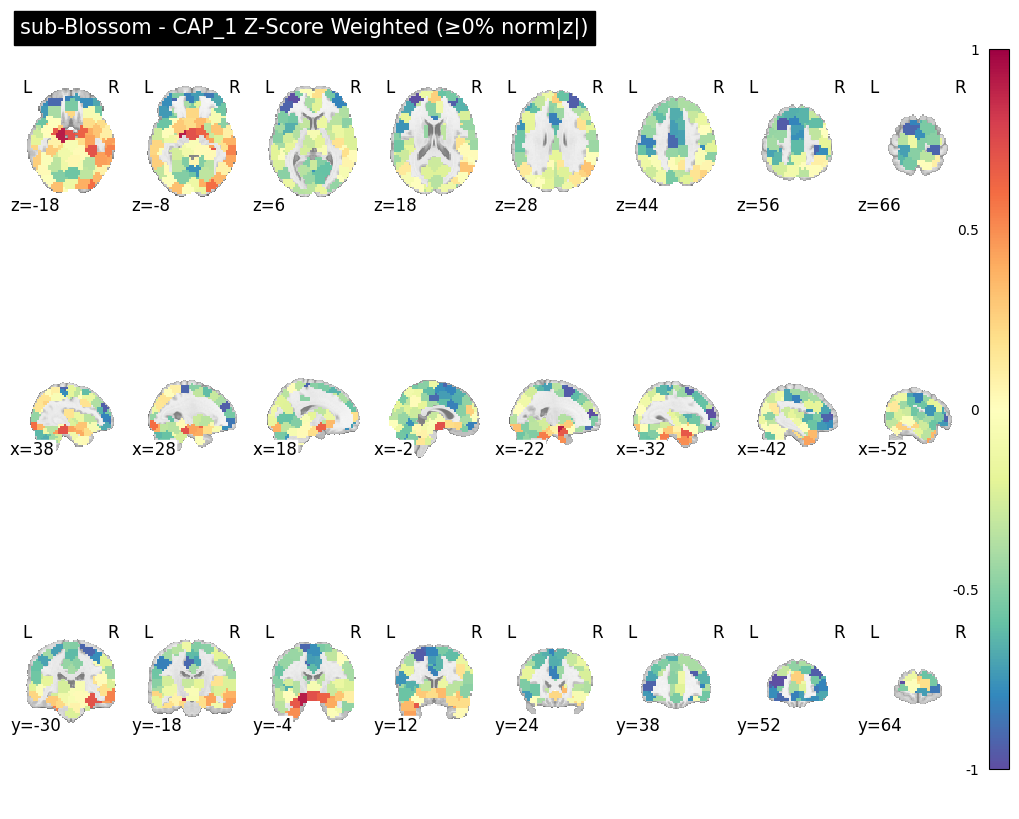

Saved positive weights: dset/derivatives/caps/caps_masks/sub-Blossom_zscore-weighted-0_CAP_1_pos.nii.gz
Saved negative weights: dset/derivatives/caps/caps_masks/sub-Blossom_zscore-weighted-0_CAP_1_neg.nii.gz


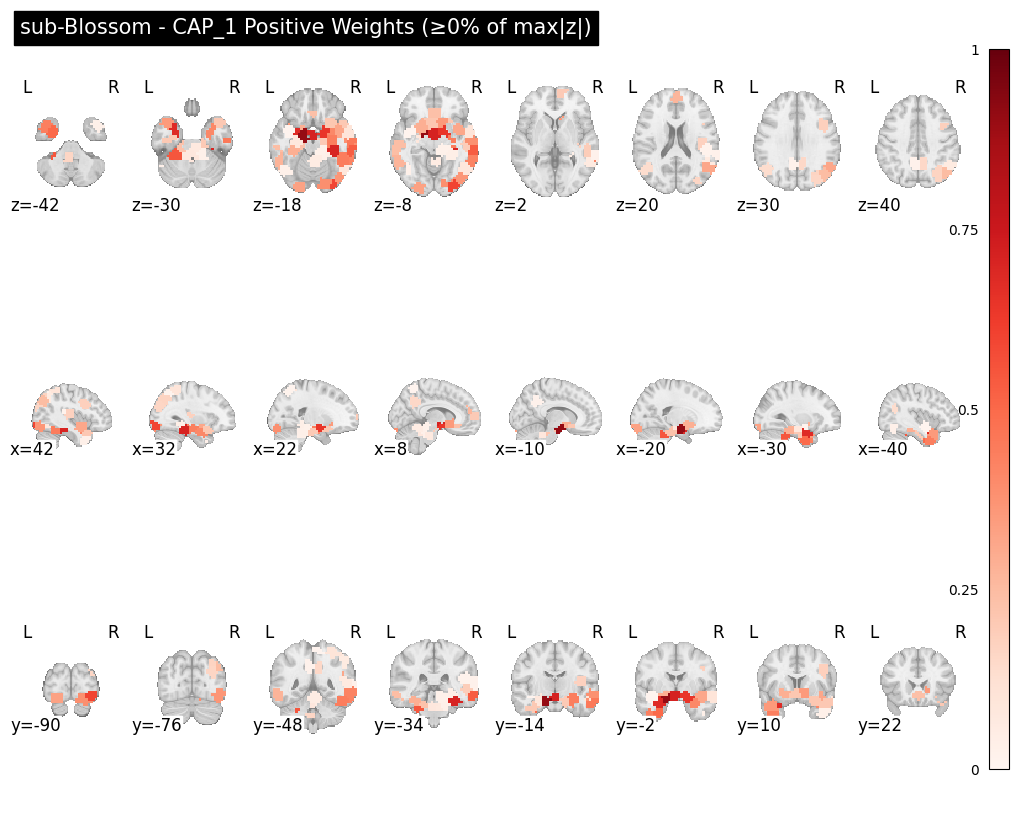

  Positive norm range: [0.010, 0.905]


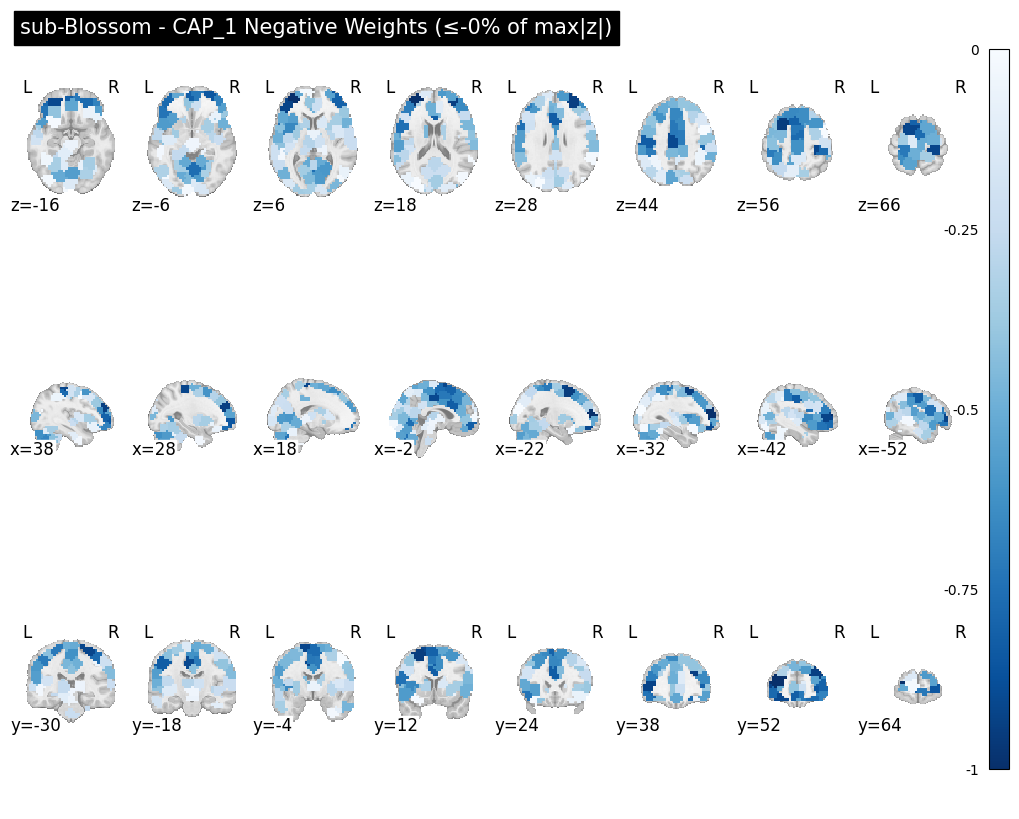

Saved z-score weighted NIfTI: dset/derivatives/caps/caps_masks/sub-Blossom_zscore-weighted-0_CAP_2.nii.gz
  Original range:    [-0.920, 0.922]
  Normalized (kept): [-0.997, 1.000]


/var/folders/w7/tr80j6dx7kz1xqvddnxtqtzr0000gn/T/ipykernel_10132/2979503926.py:44: UserWarning: Attention: At least one of the (sub)peaks falls outside of the cluster body. Identifying the nearest in-cluster voxel.
  clusters = get_clusters_table(mask_img, thr_norm, two_sided=True)


Significant clusters:
   Cluster ID     X     Y     Z  Peak Stat Cluster Size (mm3)
0           1 -42.0  38.0   6.0   1.000000             575680
1          1a -26.0  48.0 -12.0   0.927801                   
2          1b -38.0  46.0  -8.0   0.880116                   
3          1c -26.0  50.0  14.0   0.848398                   
4           2  50.0 -26.0  52.0   0.485052                 64
5           3  54.0  -2.0 -28.0   0.420657               3904
6           4 -42.0 -68.0  10.0   0.310537               9472
7          4a -46.0 -66.0  -6.0   0.134846                   
8           5  36.0 -88.0   8.0   0.268698               4352
9           6  -8.0 -76.0  40.0   0.183459               4864
10          7   2.0 -28.0 -40.0   0.059884               2944
11          8  12.0 -70.0  50.0   0.017143               4800
12          1 -14.0 -10.0 -16.0  -0.997203             566592
13         1a  18.0   0.0 -12.0  -0.877137                   
14         1b  32.0 -34.0 -22.0  -0.865875      

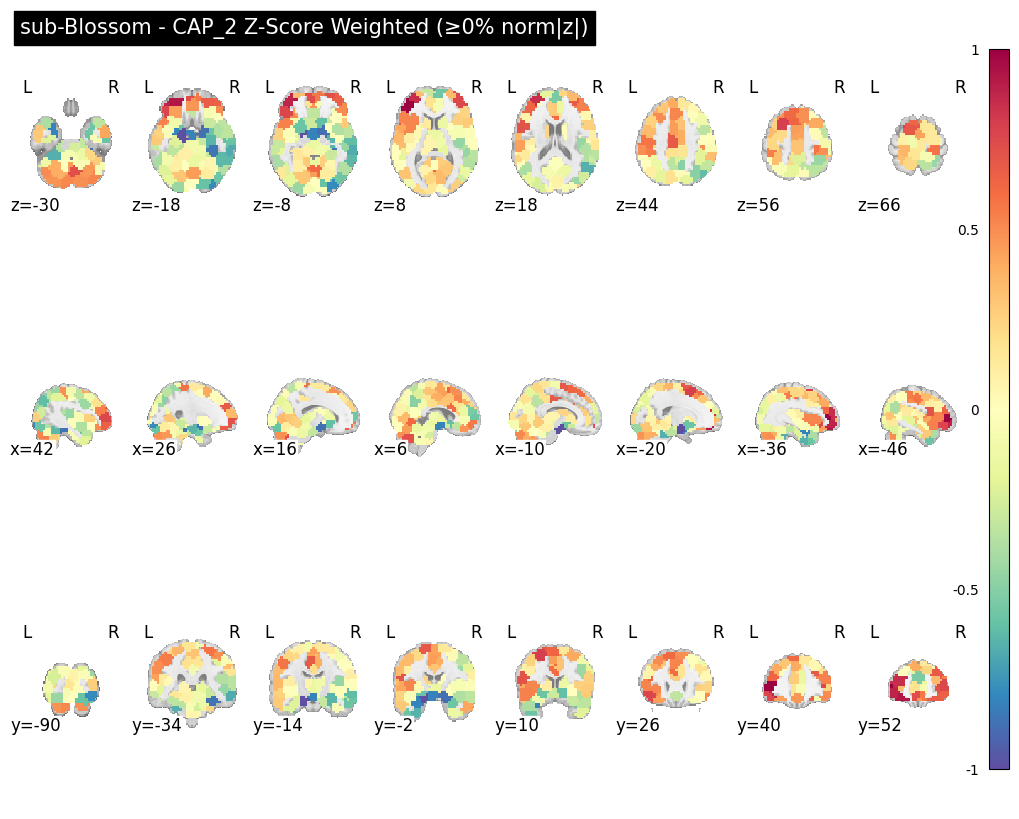

Saved positive weights: dset/derivatives/caps/caps_masks/sub-Blossom_zscore-weighted-0_CAP_2_pos.nii.gz
Saved negative weights: dset/derivatives/caps/caps_masks/sub-Blossom_zscore-weighted-0_CAP_2_neg.nii.gz


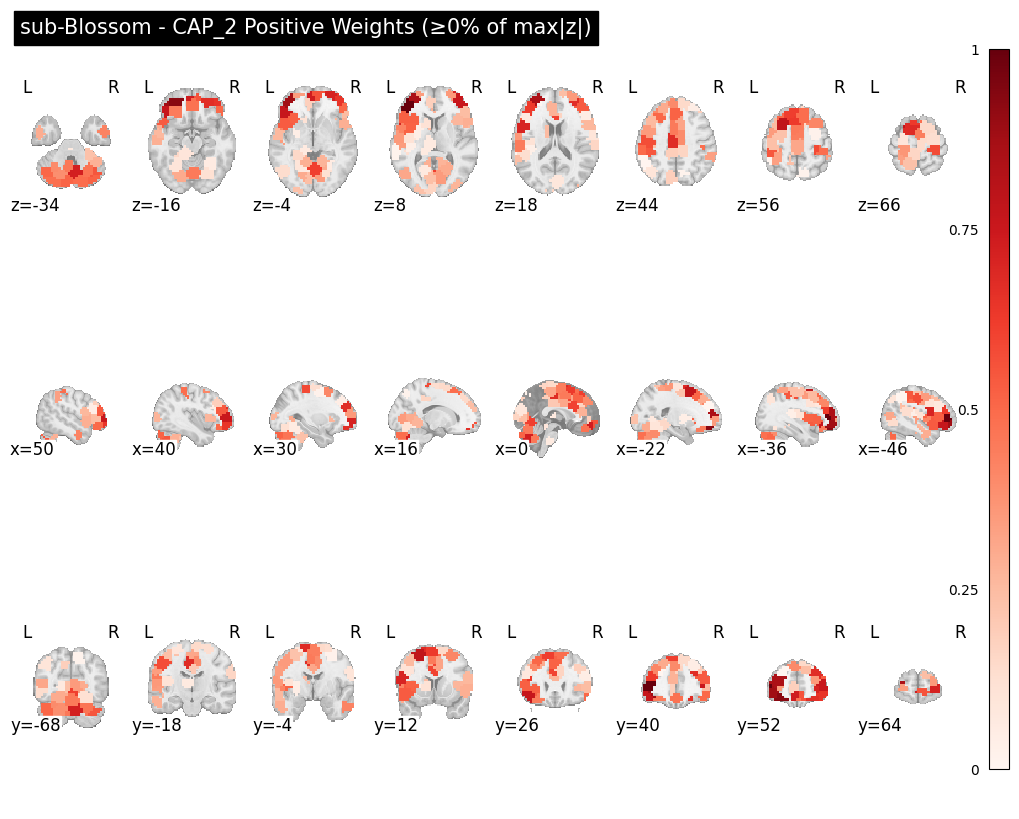

  Positive norm range: [0.001, 1.000]


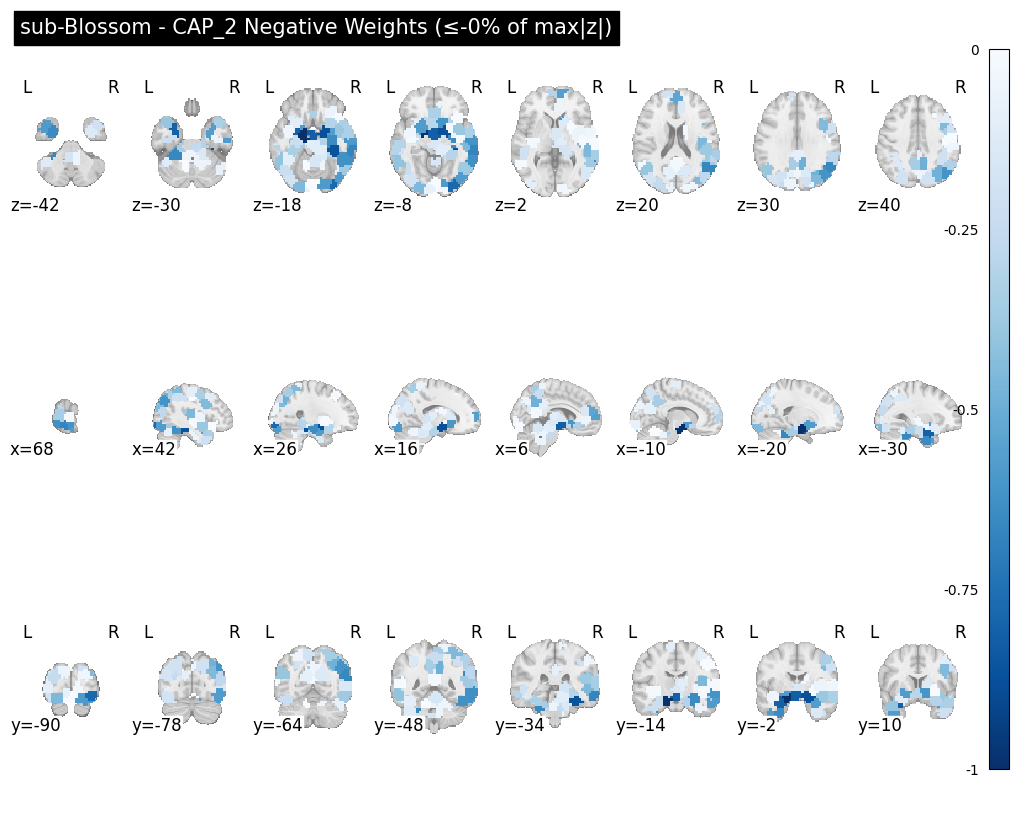

Saved z-score weighted NIfTI: dset/derivatives/caps/caps_masks/sub-Blossom_zscore-weighted-0_CAP_3.nii.gz
  Original range:    [-1.360, -0.215]
  Normalized (kept): [-1.000, -0.158]


/var/folders/w7/tr80j6dx7kz1xqvddnxtqtzr0000gn/T/ipykernel_10132/2979503926.py:44: UserWarning: Attention: No clusters with stat higher than 0.0
  clusters = get_clusters_table(mask_img, thr_norm, two_sided=True)
/var/folders/w7/tr80j6dx7kz1xqvddnxtqtzr0000gn/T/ipykernel_10132/2979503926.py:44: UserWarning: Attention: At least one of the (sub)peaks falls outside of the cluster body. Identifying the nearest in-cluster voxel.
  clusters = get_clusters_table(mask_img, thr_norm, two_sided=True)


Significant clusters:
  Cluster ID     X     Y     Z  Peak Stat Cluster Size (mm3)
0          1 -20.0 -66.0   4.0  -1.000000            1176576
1         1a -12.0 -64.0  24.0  -0.983698                   
2         1b  44.0 -60.0 -24.0  -0.973927                   
3         1c  52.0 -62.0  -4.0  -0.971473                   


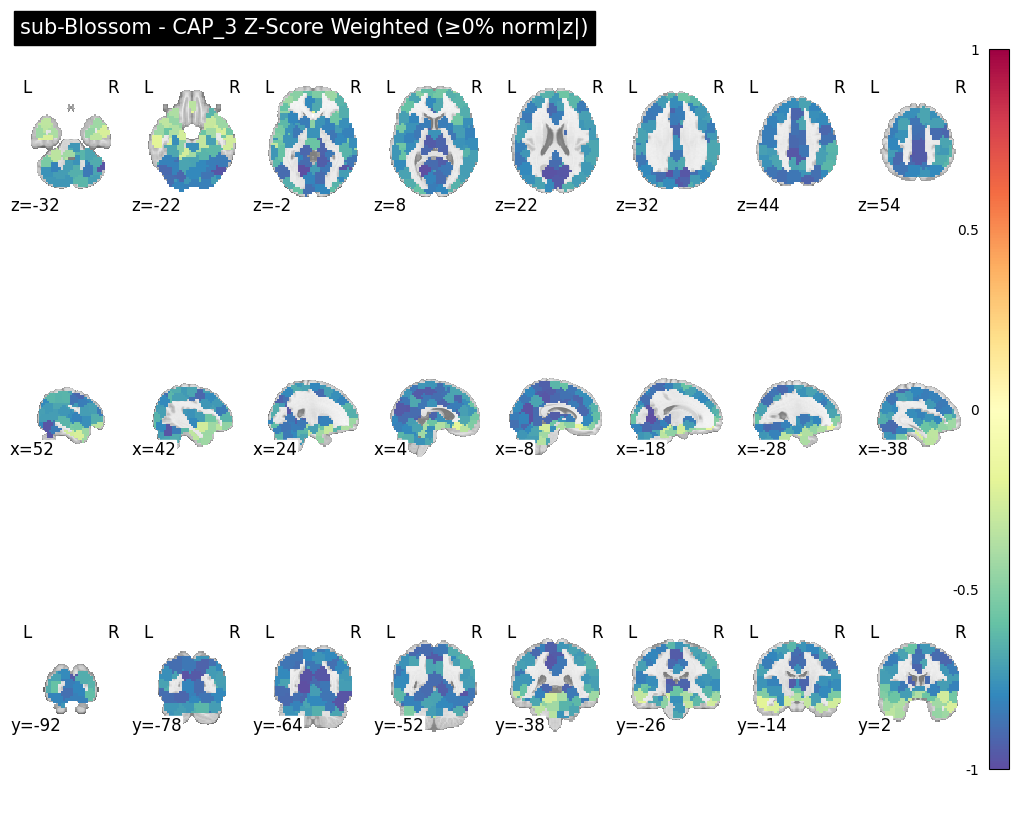

Saved positive weights: dset/derivatives/caps/caps_masks/sub-Blossom_zscore-weighted-0_CAP_3_pos.nii.gz
Saved negative weights: dset/derivatives/caps/caps_masks/sub-Blossom_zscore-weighted-0_CAP_3_neg.nii.gz
No positive activations for CAP_3


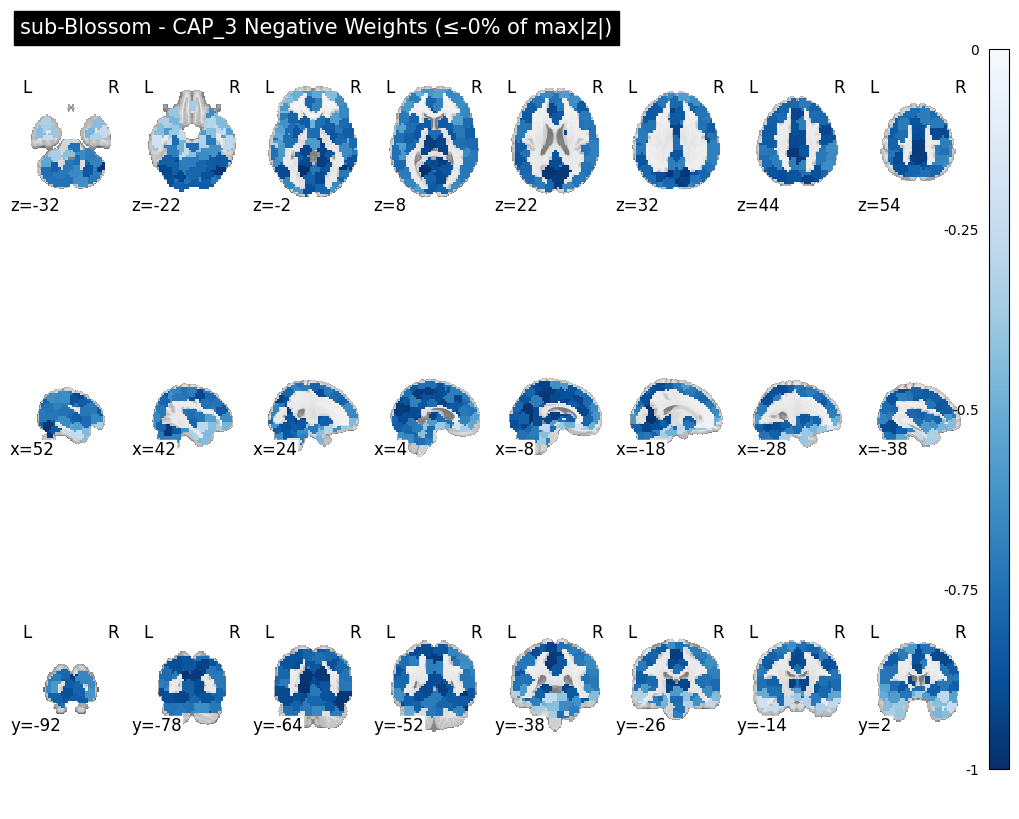

Saved z-score weighted NIfTI: dset/derivatives/caps/caps_masks/sub-Blossom_zscore-weighted-0_CAP_4.nii.gz
  Original range:    [0.067, 0.902]
  Normalized (kept): [0.074, 1.000]


/var/folders/w7/tr80j6dx7kz1xqvddnxtqtzr0000gn/T/ipykernel_10132/2979503926.py:44: UserWarning: Attention: At least one of the (sub)peaks falls outside of the cluster body. Identifying the nearest in-cluster voxel.
  clusters = get_clusters_table(mask_img, thr_norm, two_sided=True)
/var/folders/w7/tr80j6dx7kz1xqvddnxtqtzr0000gn/T/ipykernel_10132/2979503926.py:44: UserWarning: Attention: No clusters with stat lower than -0.0
  clusters = get_clusters_table(mask_img, thr_norm, two_sided=True)


Significant clusters:
  Cluster ID     X     Y     Z  Peak Stat Cluster Size (mm3)
0          1  22.0 -82.0  40.0   1.000000            1176576
1         1a  16.0 -60.0  24.0   0.981309                   
2         1b   6.0 -50.0  52.0   0.975881                   
3         1c -12.0 -64.0  24.0   0.955601                   


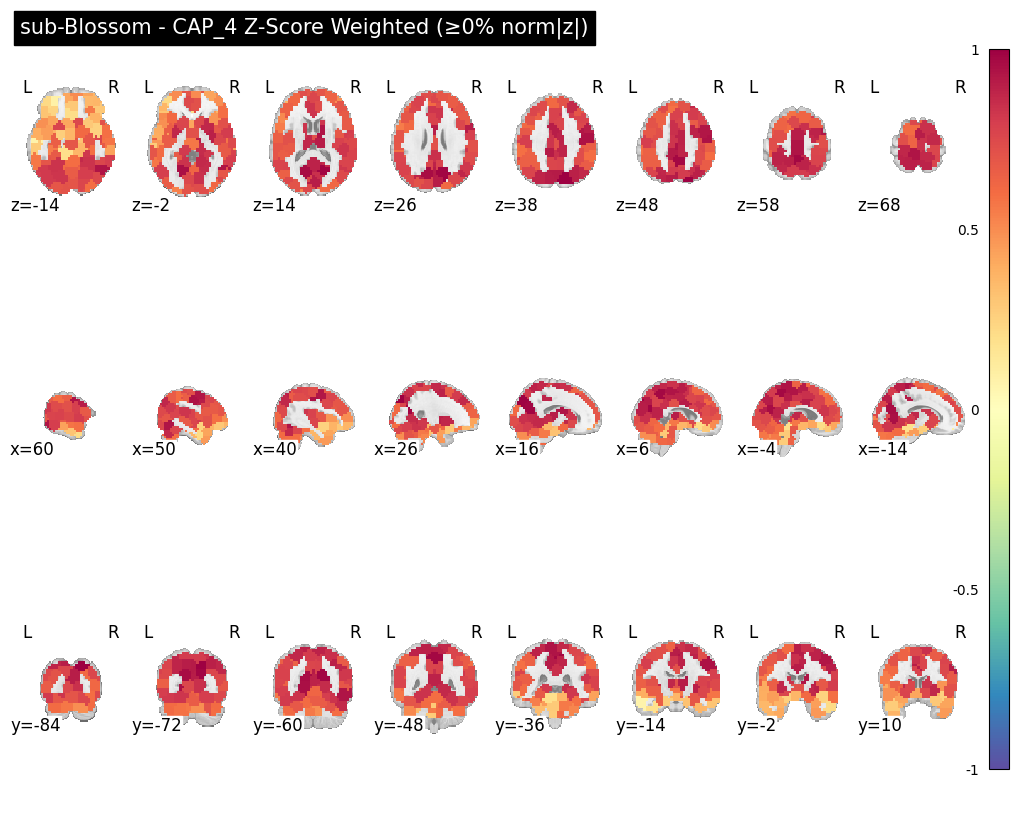

Saved positive weights: dset/derivatives/caps/caps_masks/sub-Blossom_zscore-weighted-0_CAP_4_pos.nii.gz
Saved negative weights: dset/derivatives/caps/caps_masks/sub-Blossom_zscore-weighted-0_CAP_4_neg.nii.gz


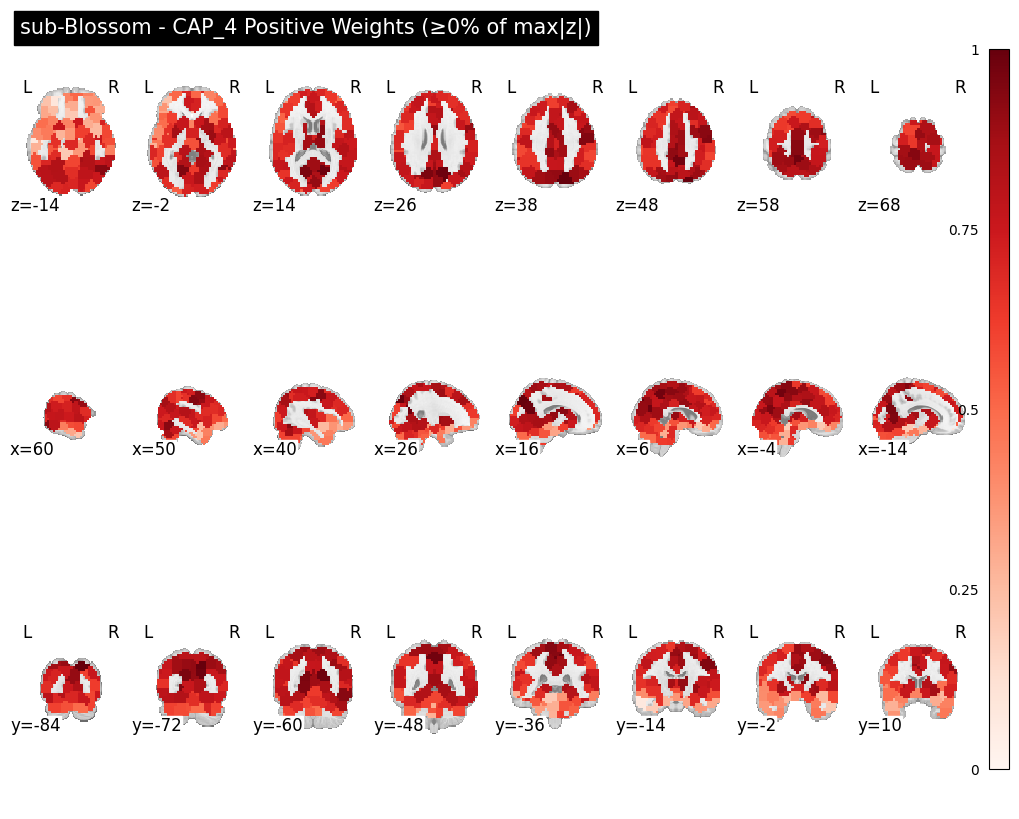

  Positive norm range: [0.074, 1.000]


PREPARING Z-SCORE NORMALIZED WEIGHTED MASKS FOR sub-Bubbles
Saved z-score weighted NIfTI: dset/derivatives/caps/caps_masks/sub-Bubbles_zscore-weighted-0_CAP_1.nii.gz
  Original range:    [-0.142, 1.195]
  Normalized (kept): [-0.119, 1.000]
Saved z-score weighted NIfTI: dset/derivatives/caps/caps_masks/sub-Bubbles_zscore-weighted-0_CAP_1.nii.gz
  Original range:    [-0.142, 1.195]
  Normalized (kept): [-0.119, 1.000]


/var/folders/w7/tr80j6dx7kz1xqvddnxtqtzr0000gn/T/ipykernel_10132/2979503926.py:44: UserWarning: Attention: At least one of the (sub)peaks falls outside of the cluster body. Identifying the nearest in-cluster voxel.
  clusters = get_clusters_table(mask_img, thr_norm, two_sided=True)


Significant clusters:
  Cluster ID     X     Y     Z  Peak Stat Cluster Size (mm3)
0          1  -6.0 -78.0  44.0   1.000000            1173120
1         1a  14.0 -32.0  44.0   0.968519                   
2         1b   2.0   4.0  48.0   0.944037                   
3         1c  -8.0 -36.0  48.0   0.938487                   
4          1  18.0 -18.0 -22.0  -0.118841               3456


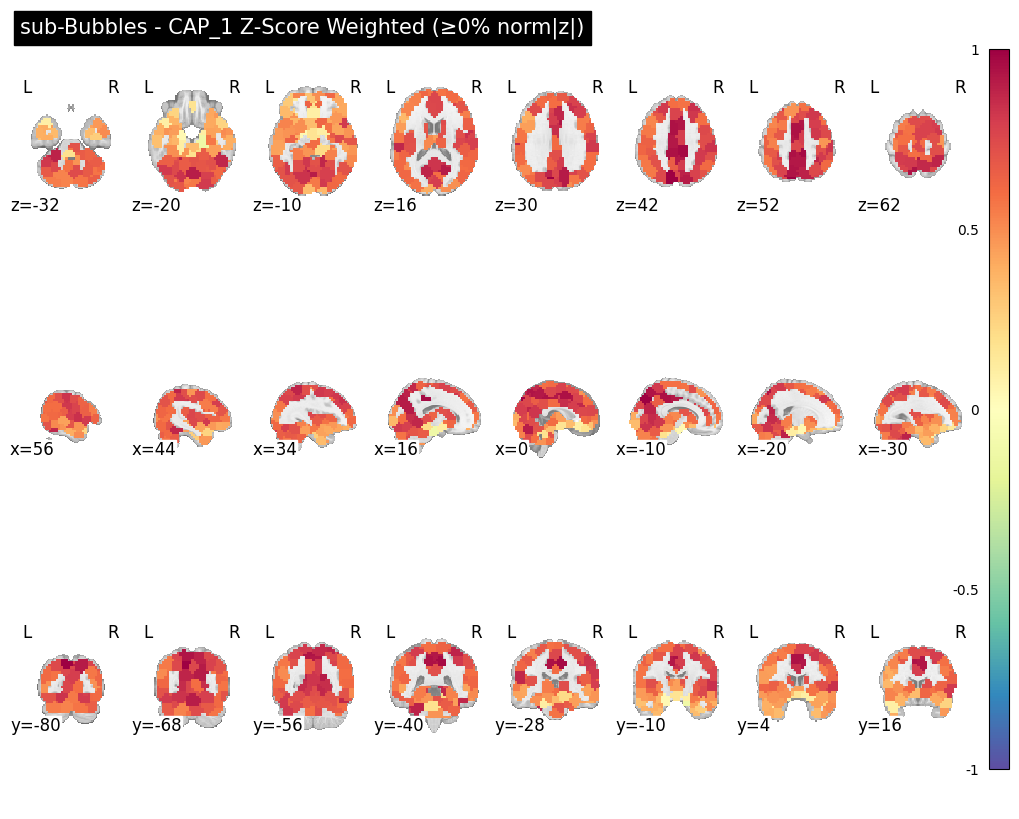

Saved positive weights: dset/derivatives/caps/caps_masks/sub-Bubbles_zscore-weighted-0_CAP_1_pos.nii.gz
Saved negative weights: dset/derivatives/caps/caps_masks/sub-Bubbles_zscore-weighted-0_CAP_1_neg.nii.gz


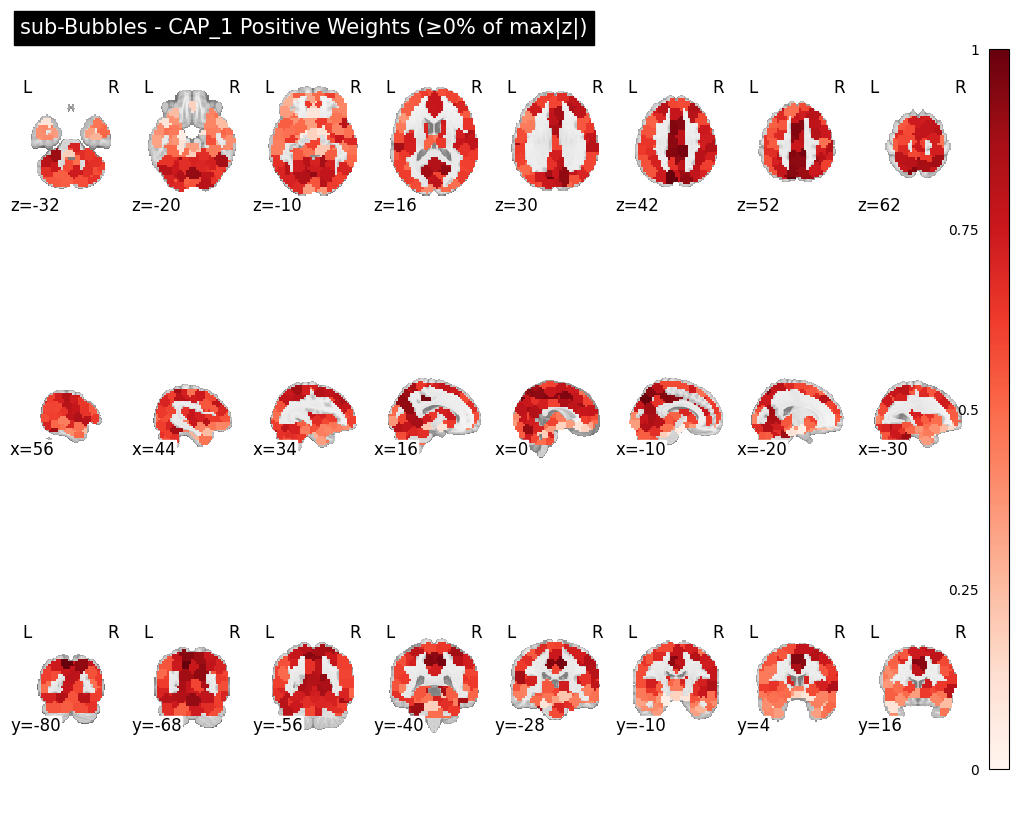

  Positive norm range: [0.039, 1.000]


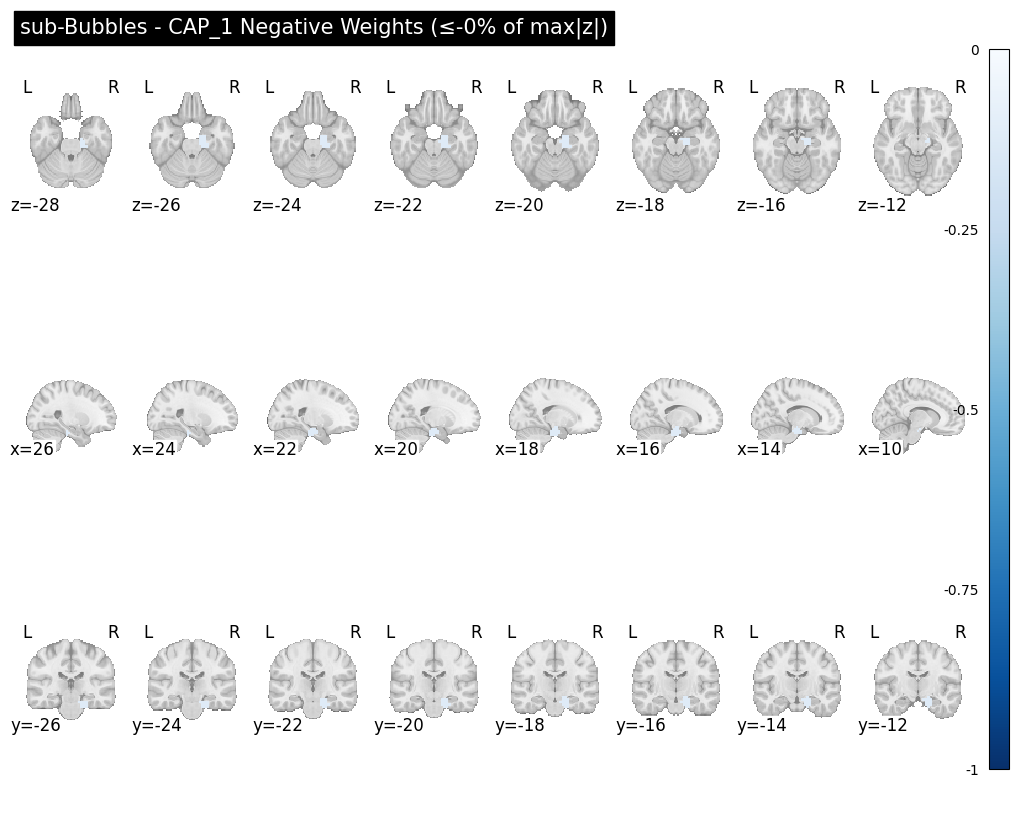

Saved z-score weighted NIfTI: dset/derivatives/caps/caps_masks/sub-Bubbles_zscore-weighted-0_CAP_2.nii.gz
  Original range:    [-0.611, 0.703]
  Normalized (kept): [-0.869, 1.000]


/var/folders/w7/tr80j6dx7kz1xqvddnxtqtzr0000gn/T/ipykernel_10132/2979503926.py:44: UserWarning: Attention: At least one of the (sub)peaks falls outside of the cluster body. Identifying the nearest in-cluster voxel.
  clusters = get_clusters_table(mask_img, thr_norm, two_sided=True)


Significant clusters:
   Cluster ID     X     Y     Z  Peak Stat Cluster Size (mm3)
0           1 -40.0 -48.0 -16.0   1.000000             644096
1          1a -44.0 -66.0 -22.0   0.977625                   
2          1b  44.0 -76.0  -8.0   0.964884                   
3          1c -38.0 -76.0  22.0   0.955309                   
4           2  62.0   0.0 -14.0   0.253918               9280
5          2a  50.0  16.0 -24.0   0.200559                   
6           3  42.0  10.0  30.0   0.249515               4480
7           1  28.0  54.0  -2.0  -0.869329             495744
8          1a  42.0 -18.0  60.0  -0.864717                   
9          1b  28.0  46.0  28.0  -0.774823                   
10         1c  46.0  34.0  18.0  -0.770552                   
11          2   2.0 -70.0  36.0  -0.199734               3456
12          3 -10.0 -66.0  36.0  -0.199734                 64
13          4 -42.0   6.0 -40.0  -0.120778               3456
14          5   6.0 -50.0 -18.0  -0.086895      

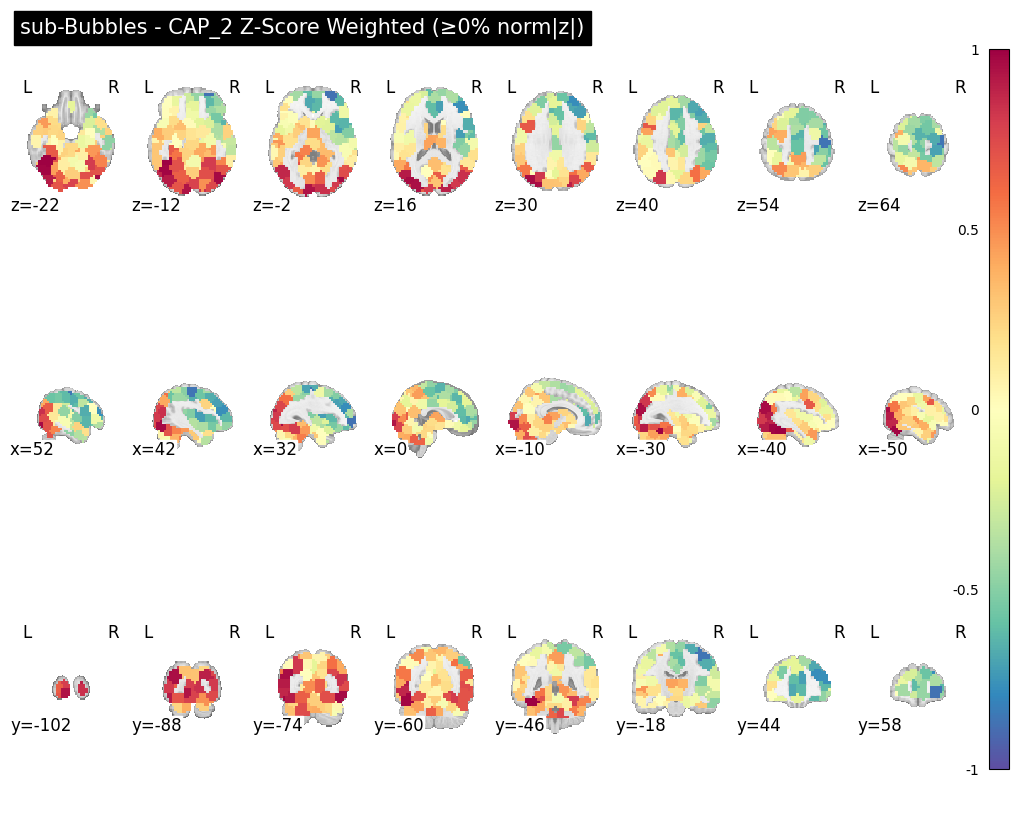

Saved positive weights: dset/derivatives/caps/caps_masks/sub-Bubbles_zscore-weighted-0_CAP_2_pos.nii.gz
Saved negative weights: dset/derivatives/caps/caps_masks/sub-Bubbles_zscore-weighted-0_CAP_2_neg.nii.gz


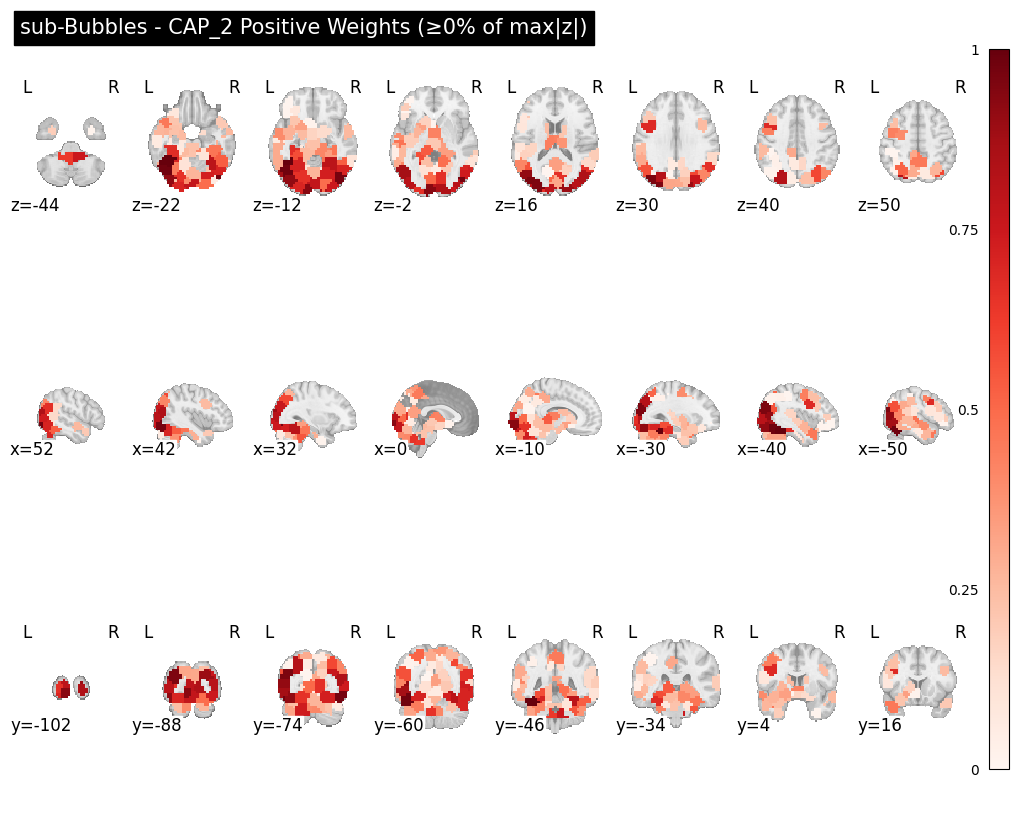

  Positive norm range: [0.005, 1.000]


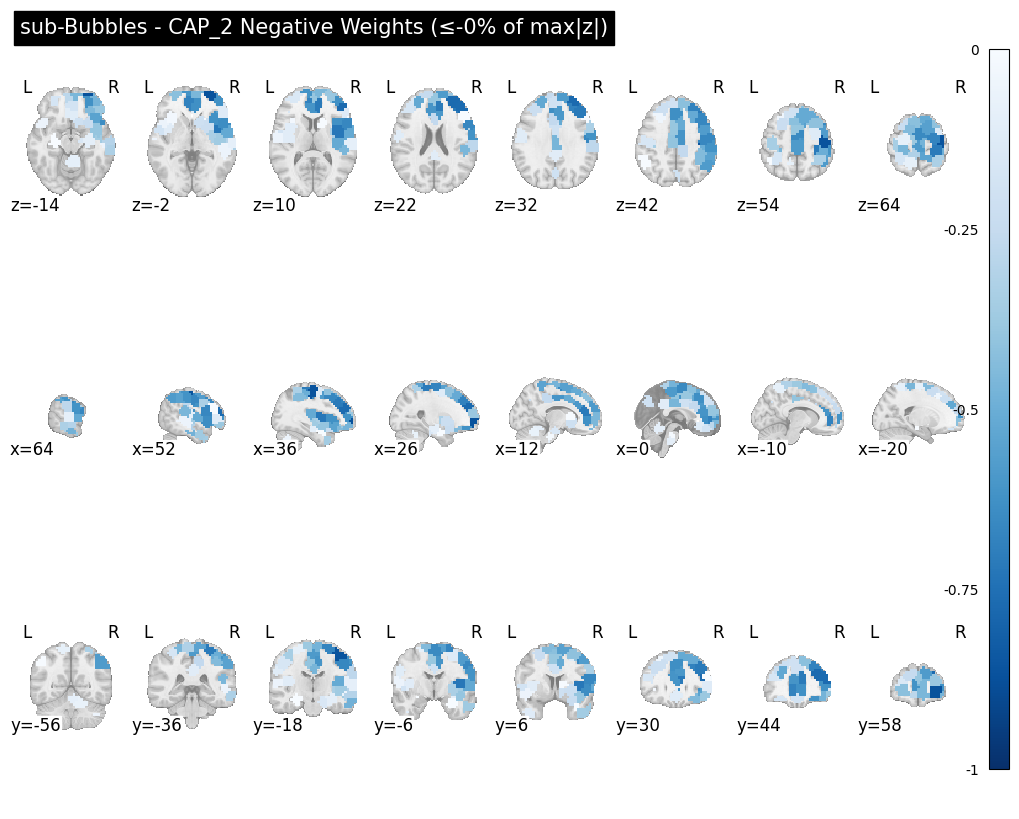

Saved z-score weighted NIfTI: dset/derivatives/caps/caps_masks/sub-Bubbles_zscore-weighted-0_CAP_3.nii.gz
  Original range:    [-0.893, 0.920]
  Normalized (kept): [-0.971, 1.000]


/var/folders/w7/tr80j6dx7kz1xqvddnxtqtzr0000gn/T/ipykernel_10132/2979503926.py:44: UserWarning: Attention: At least one of the (sub)peaks falls outside of the cluster body. Identifying the nearest in-cluster voxel.
  clusters = get_clusters_table(mask_img, thr_norm, two_sided=True)


Significant clusters:
  Cluster ID     X     Y     Z  Peak Stat Cluster Size (mm3)
0          1  46.0  18.0  44.0   1.000000             745536
1         1a  50.0  -2.0  46.0   0.949009                   
2         1b  42.0  30.0  30.0   0.927628                   
3         1c  44.0  40.0  14.0   0.912683                   
4          2 -36.0 -14.0 -28.0   0.253120               2560
5          1 -48.0  -2.0  48.0  -0.970558             423616
6         1a -42.0  38.0   6.0  -0.817588                   
7         1b -50.0 -34.0 -16.0  -0.793925                   
8         1c -58.0 -26.0  -8.0  -0.793925                   
9          2  62.0 -48.0  -8.0  -0.093055               4864


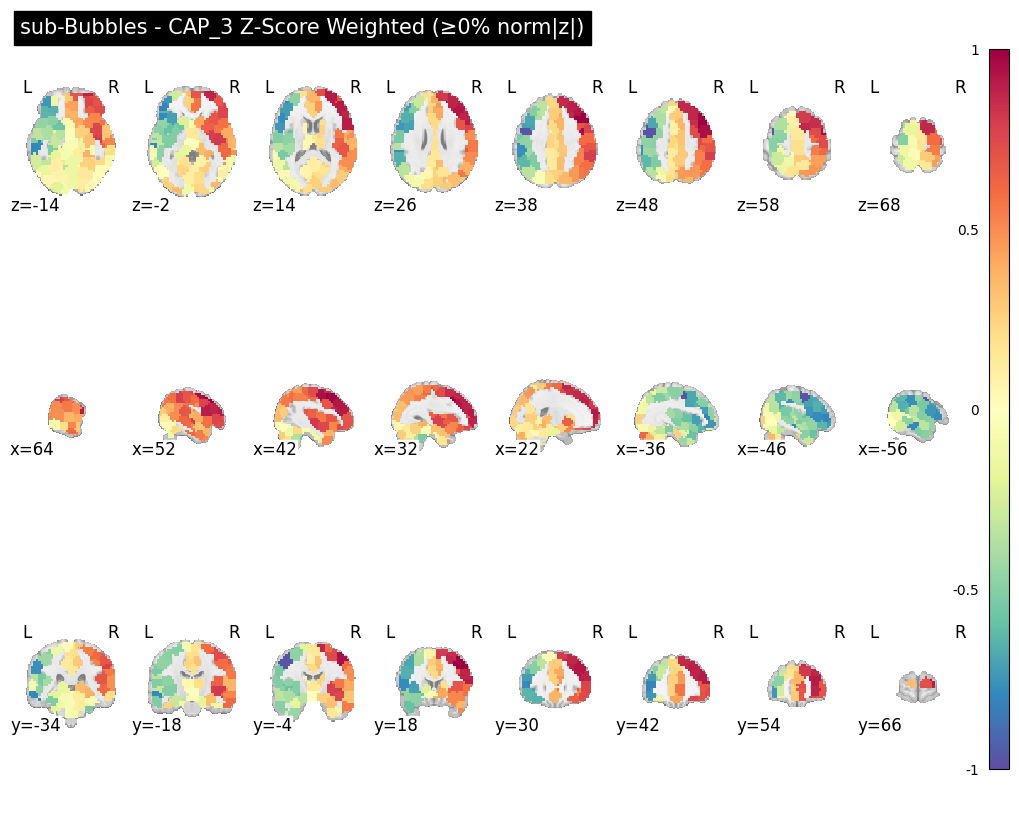

Saved positive weights: dset/derivatives/caps/caps_masks/sub-Bubbles_zscore-weighted-0_CAP_3_pos.nii.gz
Saved negative weights: dset/derivatives/caps/caps_masks/sub-Bubbles_zscore-weighted-0_CAP_3_neg.nii.gz


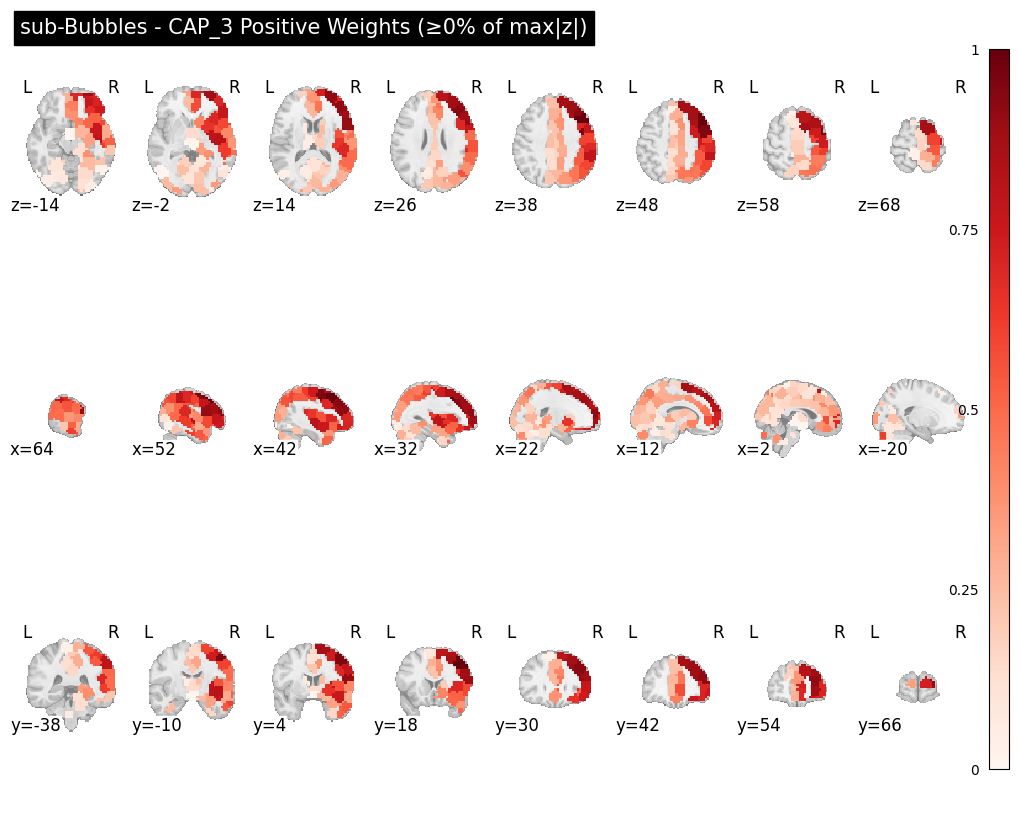

  Positive norm range: [0.003, 1.000]


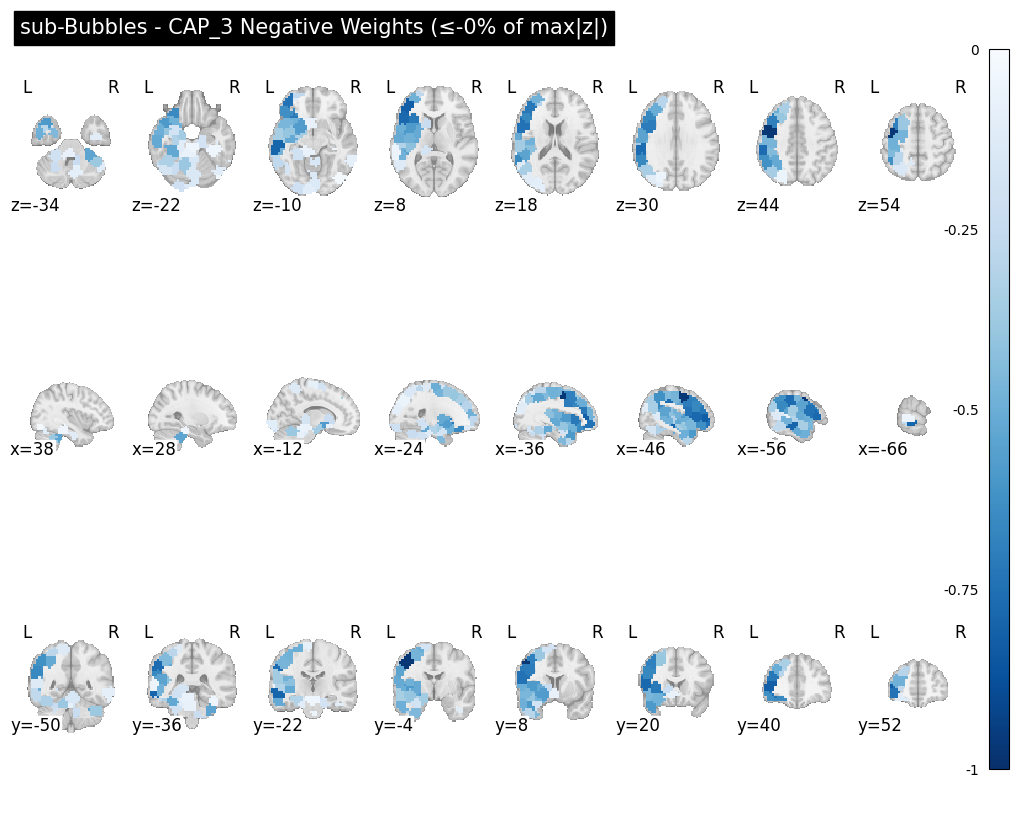

Saved z-score weighted NIfTI: dset/derivatives/caps/caps_masks/sub-Bubbles_zscore-weighted-0_CAP_4.nii.gz
  Original range:    [-1.025, 0.145]
  Normalized (kept): [-1.000, 0.141]


/var/folders/w7/tr80j6dx7kz1xqvddnxtqtzr0000gn/T/ipykernel_10132/2979503926.py:44: UserWarning: Attention: At least one of the (sub)peaks falls outside of the cluster body. Identifying the nearest in-cluster voxel.
  clusters = get_clusters_table(mask_img, thr_norm, two_sided=True)


Significant clusters:
  Cluster ID     X     Y     Z  Peak Stat Cluster Size (mm3)
0          1  18.0 -18.0 -22.0   0.141037               3456
1          1  -8.0 -36.0  48.0  -1.000000            1173120
2         1a  14.0 -32.0  44.0  -0.953410                   
3         1b  -6.0 -78.0  44.0  -0.952184                   
4         1c   6.0 -50.0  52.0  -0.951987                   


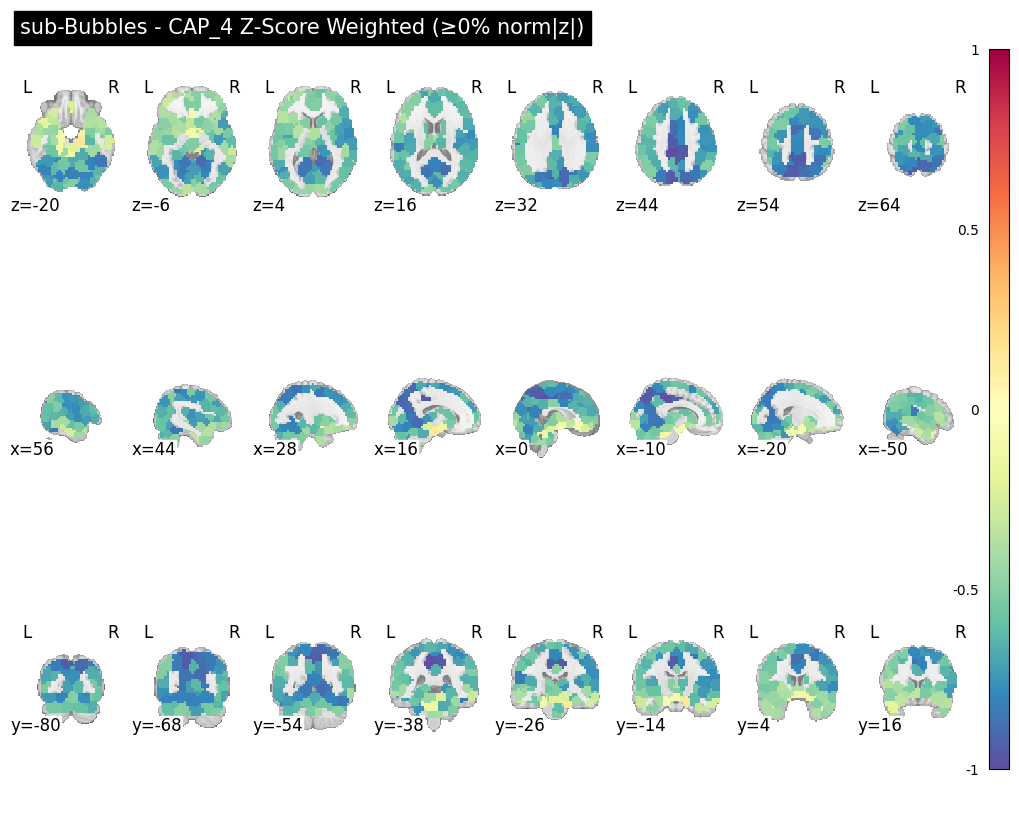

Saved positive weights: dset/derivatives/caps/caps_masks/sub-Bubbles_zscore-weighted-0_CAP_4_pos.nii.gz
Saved negative weights: dset/derivatives/caps/caps_masks/sub-Bubbles_zscore-weighted-0_CAP_4_neg.nii.gz


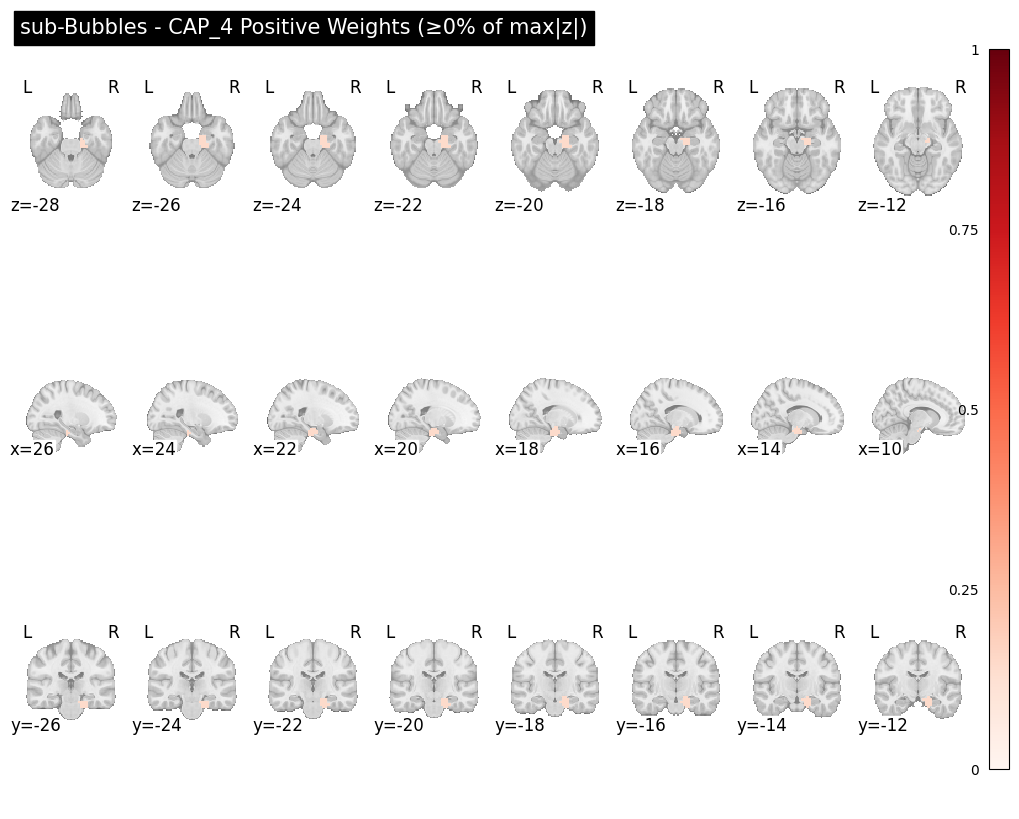

  Positive norm range: [0.141, 0.141]


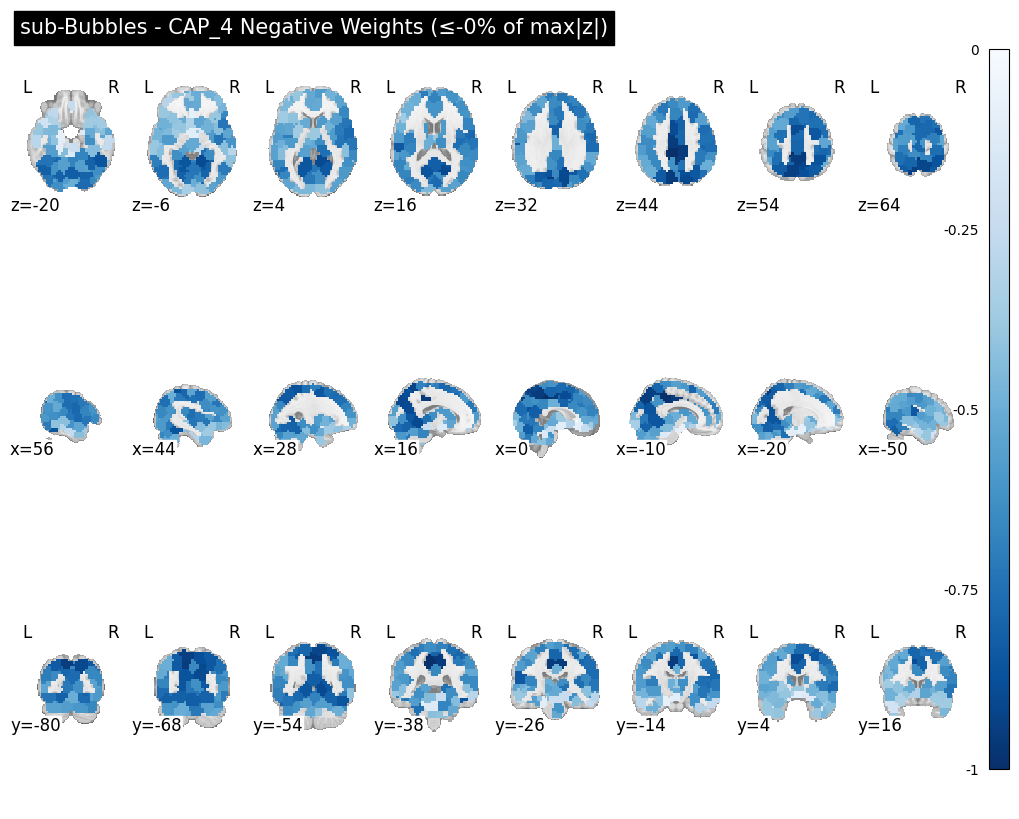

Saved z-score weighted NIfTI: dset/derivatives/caps/caps_masks/sub-Bubbles_zscore-weighted-0_CAP_5.nii.gz
  Original range:    [-0.653, 0.706]
  Normalized (kept): [-0.925, 1.000]


/var/folders/w7/tr80j6dx7kz1xqvddnxtqtzr0000gn/T/ipykernel_10132/2979503926.py:44: UserWarning: Attention: At least one of the (sub)peaks falls outside of the cluster body. Identifying the nearest in-cluster voxel.
  clusters = get_clusters_table(mask_img, thr_norm, two_sided=True)


Significant clusters:
   Cluster ID     X     Y     Z  Peak Stat Cluster Size (mm3)
0           1 -34.0 -22.0  56.0   1.000000             457344
1          1a -44.0  36.0  20.0   0.977793                   
2          1b -50.0   2.0  18.0   0.876856                   
3          1c -38.0  46.0  -8.0   0.869188                   
4           2   6.0 -50.0 -18.0   0.392587              35200
5          2a -16.0 -56.0 -24.0   0.318816                   
6          2b  22.0 -18.0 -22.0   0.258978                   
7          2c  34.0 -42.0 -34.0   0.062928                   
8           3   2.0 -28.0 -40.0   0.230955               2944
9           4 -10.0 -68.0  22.0   0.157078               6144
10          1  -4.0 -58.0 -32.0  -0.925234             670656
11         1a  38.0 -90.0   8.0  -0.874611                   
12         1b  20.0 -94.0  20.0  -0.874505                   
13         1c  46.0 -72.0  20.0  -0.843429                   
14          2 -36.0 -14.0 -28.0  -0.064456      

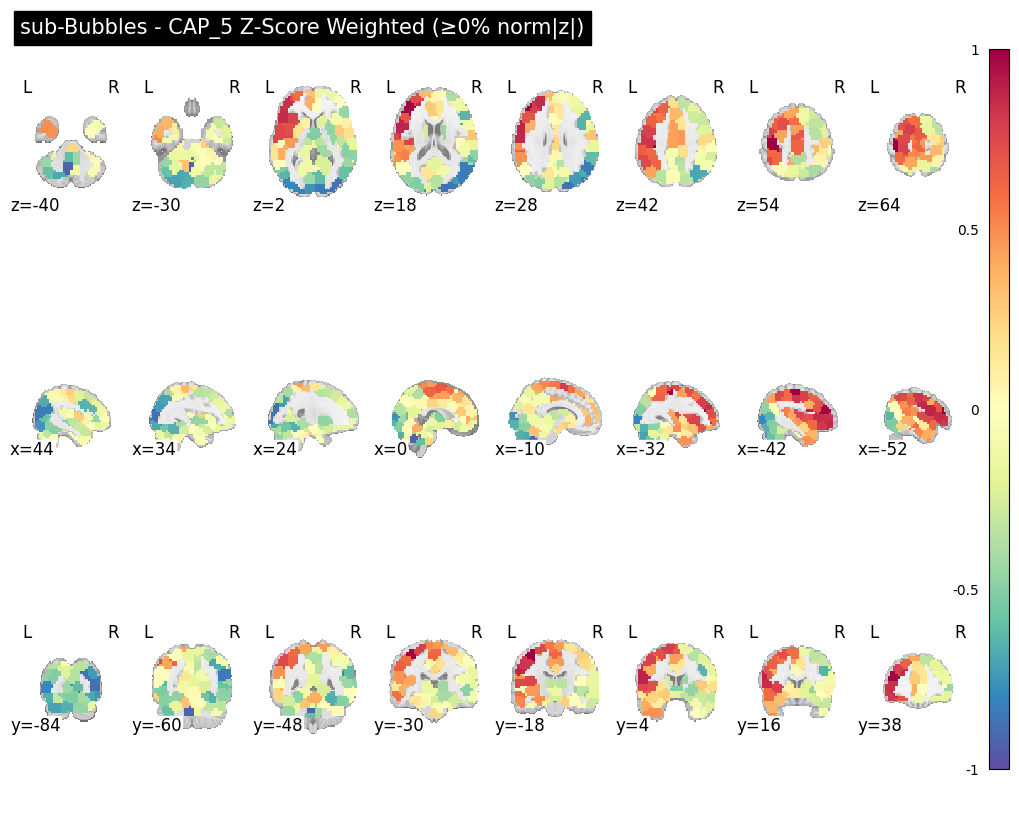

Saved positive weights: dset/derivatives/caps/caps_masks/sub-Bubbles_zscore-weighted-0_CAP_5_pos.nii.gz
Saved negative weights: dset/derivatives/caps/caps_masks/sub-Bubbles_zscore-weighted-0_CAP_5_neg.nii.gz


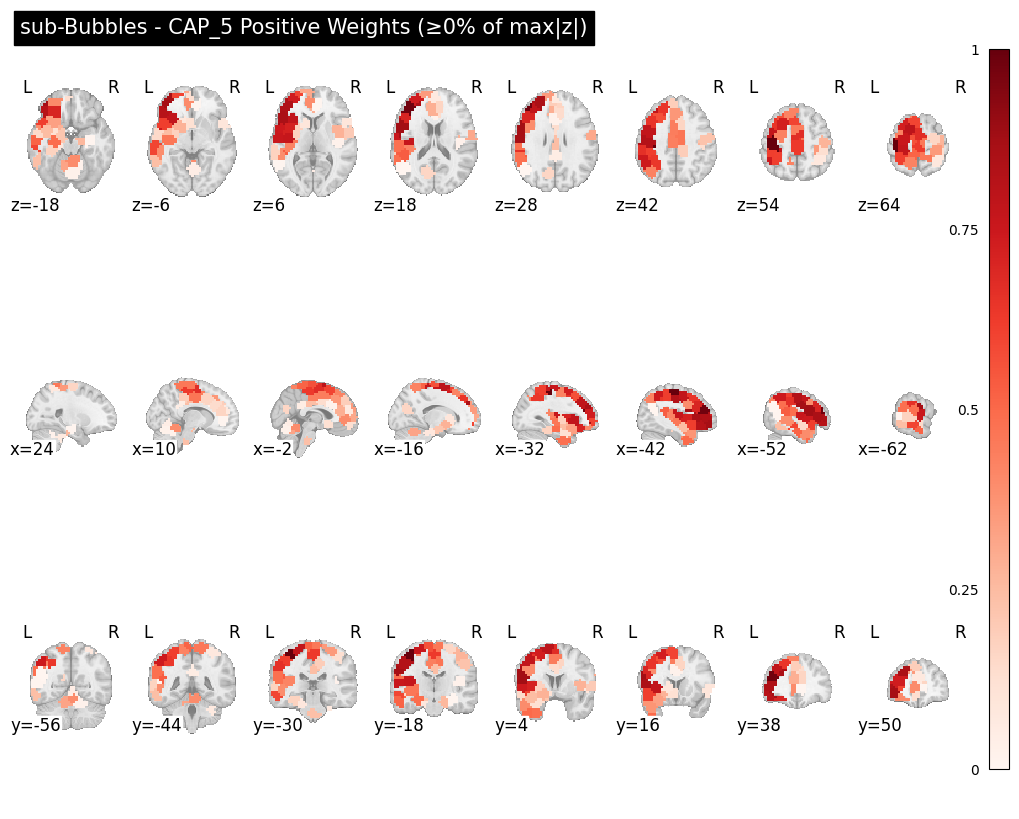

  Positive norm range: [0.002, 1.000]


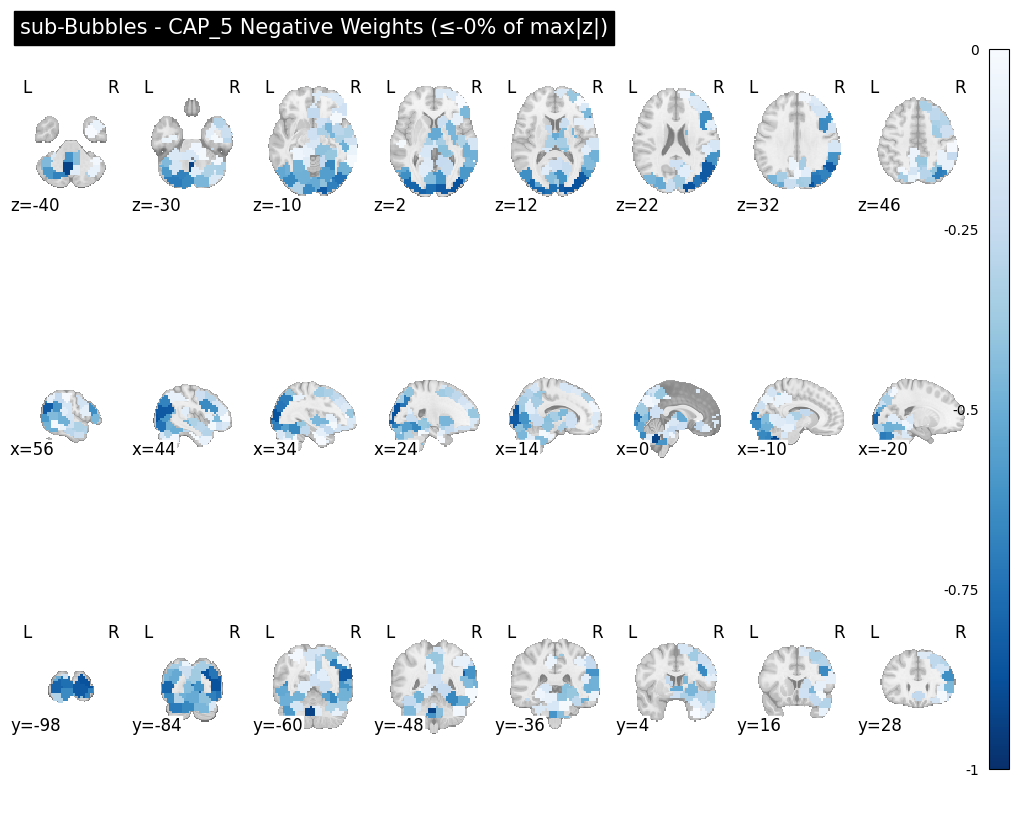



PREPARING Z-SCORE NORMALIZED WEIGHTED MASKS FOR sub-Buttercup
Saved z-score weighted NIfTI: dset/derivatives/caps/caps_masks/sub-Buttercup_zscore-weighted-0_CAP_1.nii.gz
  Original range:    [-0.149, 1.008]
  Normalized (kept): [-0.148, 1.000]
Saved z-score weighted NIfTI: dset/derivatives/caps/caps_masks/sub-Buttercup_zscore-weighted-0_CAP_1.nii.gz
  Original range:    [-0.149, 1.008]
  Normalized (kept): [-0.148, 1.000]


/var/folders/w7/tr80j6dx7kz1xqvddnxtqtzr0000gn/T/ipykernel_10132/2979503926.py:44: UserWarning: Attention: At least one of the (sub)peaks falls outside of the cluster body. Identifying the nearest in-cluster voxel.
  clusters = get_clusters_table(mask_img, thr_norm, two_sided=True)


Significant clusters:
  Cluster ID     X     Y     Z  Peak Stat Cluster Size (mm3)
0          1   6.0 -26.0  54.0   1.000000            1166016
1         1a   6.0 -50.0  52.0   0.991438                   
2         1b  18.0 -42.0  72.0   0.965212                   
3         1c  -8.0 -16.0  44.0   0.943787                   
4          1   0.0  32.0 -10.0  -0.147626               7488
5         1a  -4.0  12.0  -4.0  -0.005042                   
6          2 -18.0 -26.0 -24.0  -0.026754               3072


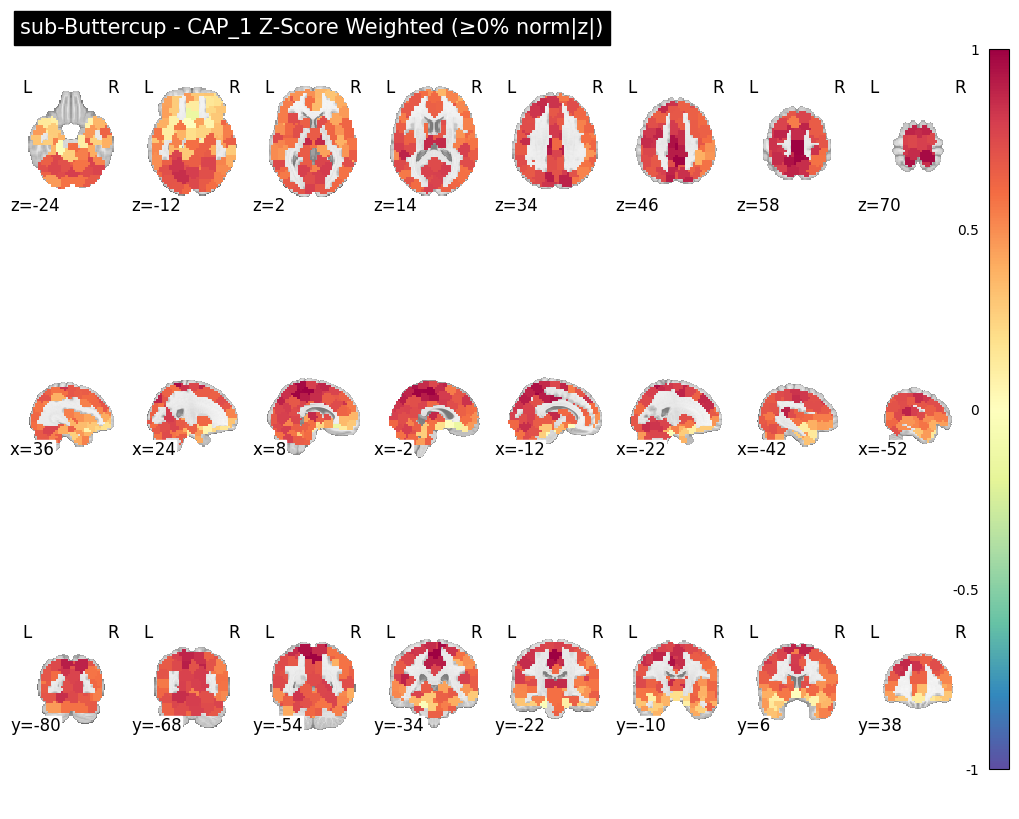

Saved positive weights: dset/derivatives/caps/caps_masks/sub-Buttercup_zscore-weighted-0_CAP_1_pos.nii.gz
Saved negative weights: dset/derivatives/caps/caps_masks/sub-Buttercup_zscore-weighted-0_CAP_1_neg.nii.gz


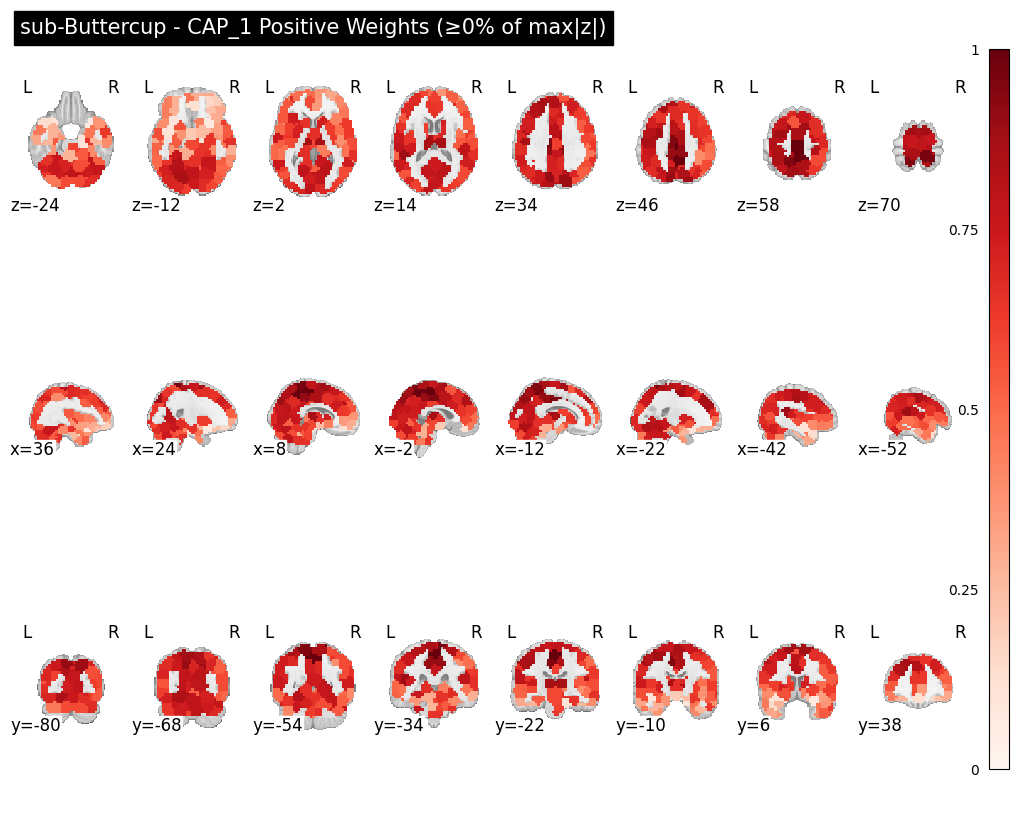

  Positive norm range: [0.068, 1.000]


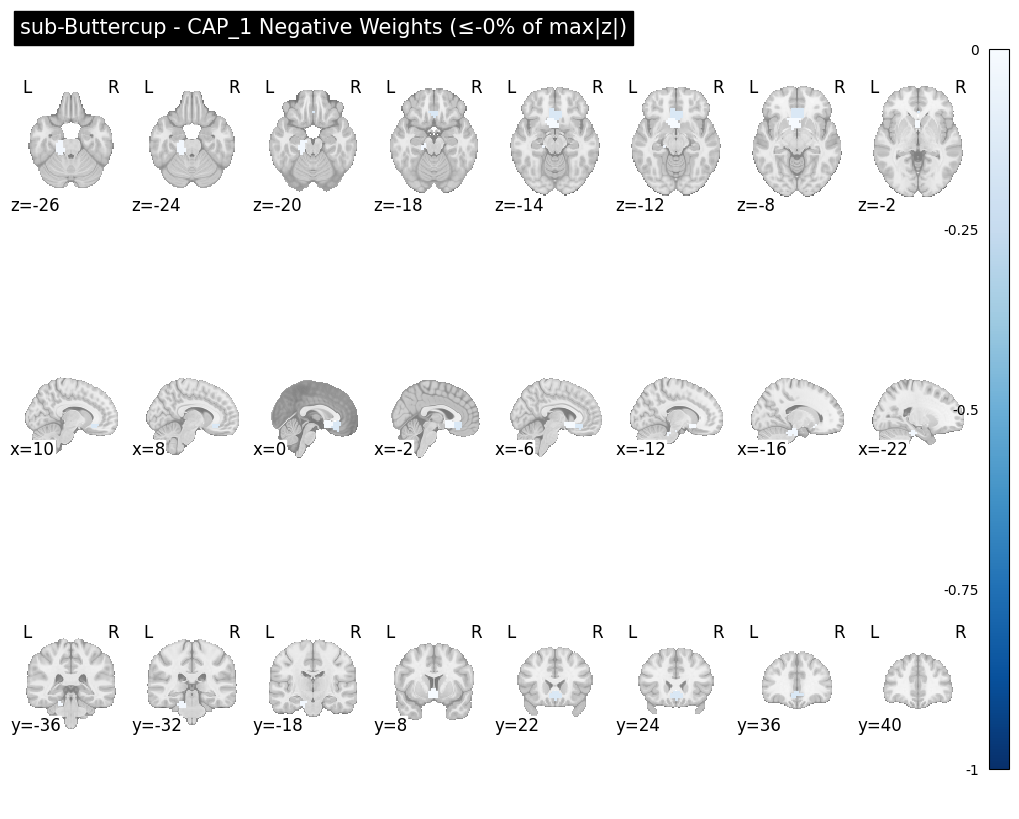

Saved z-score weighted NIfTI: dset/derivatives/caps/caps_masks/sub-Buttercup_zscore-weighted-0_CAP_2.nii.gz
  Original range:    [-2.092, 0.035]
  Normalized (kept): [-1.000, 0.017]


/var/folders/w7/tr80j6dx7kz1xqvddnxtqtzr0000gn/T/ipykernel_10132/2979503926.py:44: UserWarning: Attention: At least one of the (sub)peaks falls outside of the cluster body. Identifying the nearest in-cluster voxel.
  clusters = get_clusters_table(mask_img, thr_norm, two_sided=True)


Significant clusters:
  Cluster ID     X     Y     Z  Peak Stat Cluster Size (mm3)
0          1   0.0  28.0 -10.0   0.016939               3840
1          1   6.0 -50.0  52.0  -1.000000            1172736
2         1a  -8.0 -22.0  10.0  -0.998641                   
3         1b   2.0 -24.0  60.0  -0.986975                   
4         1c -42.0 -60.0 -18.0  -0.972090                   


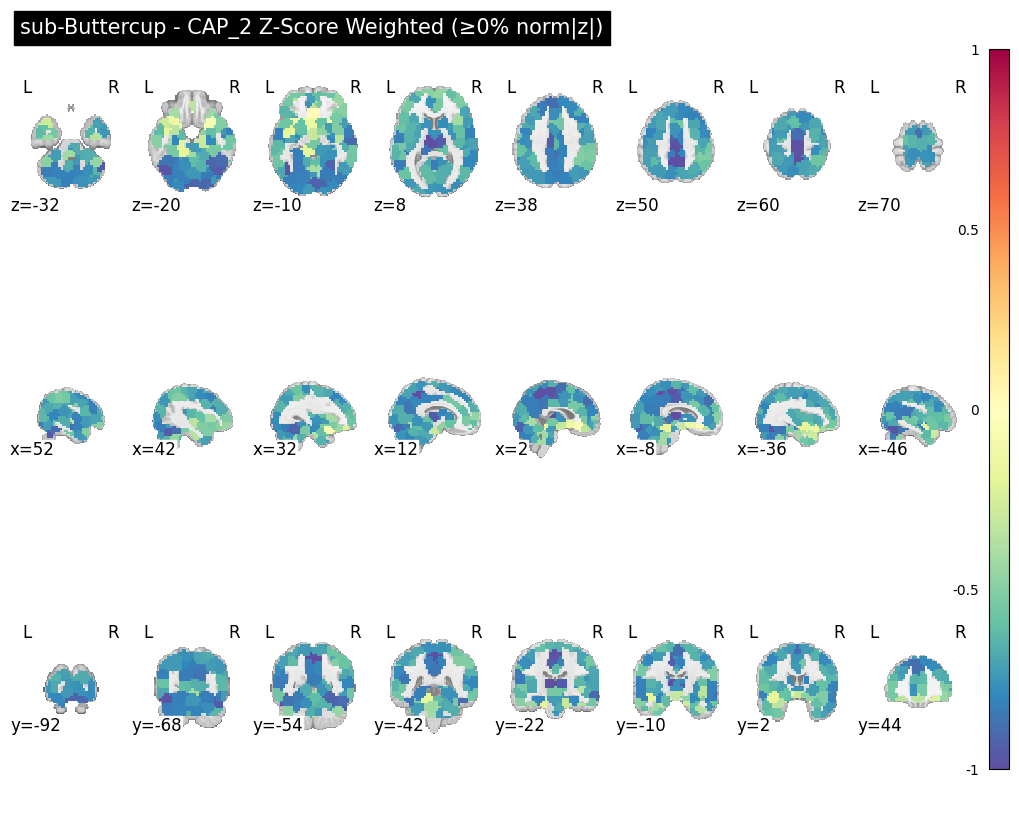

Saved positive weights: dset/derivatives/caps/caps_masks/sub-Buttercup_zscore-weighted-0_CAP_2_pos.nii.gz
Saved negative weights: dset/derivatives/caps/caps_masks/sub-Buttercup_zscore-weighted-0_CAP_2_neg.nii.gz


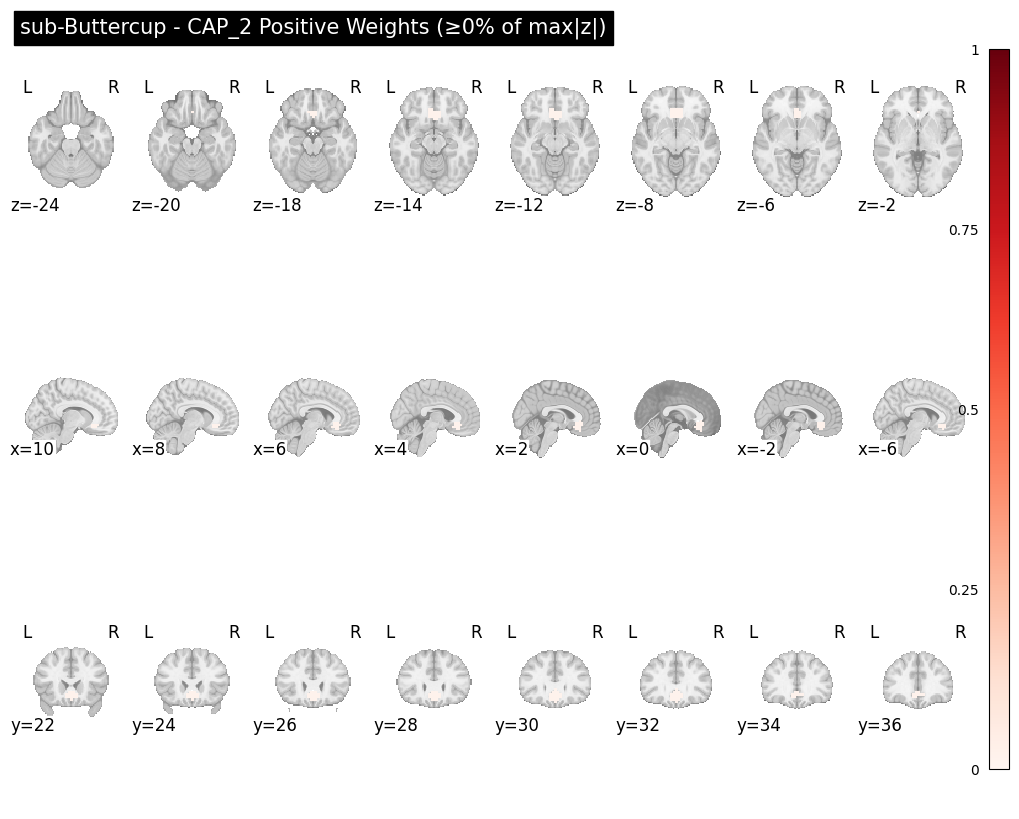

  Positive norm range: [0.017, 0.017]


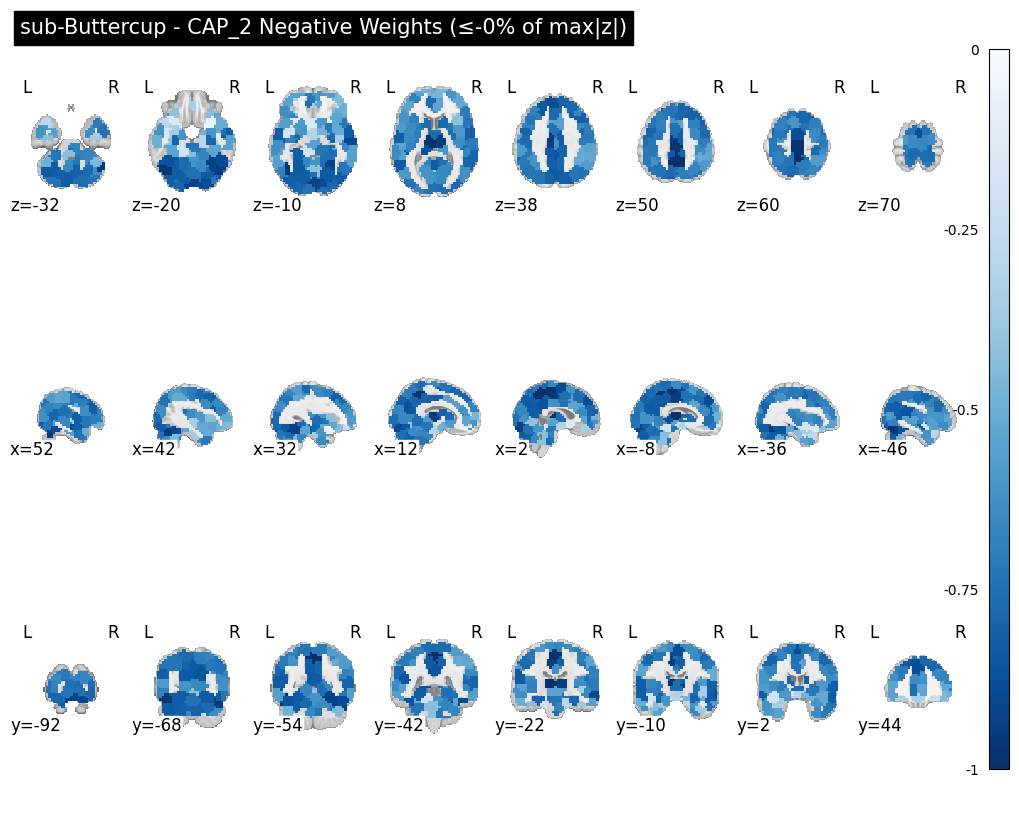

Saved z-score weighted NIfTI: dset/derivatives/caps/caps_masks/sub-Buttercup_zscore-weighted-0_CAP_3.nii.gz
  Original range:    [-0.705, 0.058]
  Normalized (kept): [-1.000, 0.082]


/var/folders/w7/tr80j6dx7kz1xqvddnxtqtzr0000gn/T/ipykernel_10132/2979503926.py:44: UserWarning: Attention: At least one of the (sub)peaks falls outside of the cluster body. Identifying the nearest in-cluster voxel.
  clusters = get_clusters_table(mask_img, thr_norm, two_sided=True)


Significant clusters:
  Cluster ID     X     Y     Z  Peak Stat Cluster Size (mm3)
0          1   0.0  32.0 -10.0   0.081963               7360
1         1a   2.0  44.0 -12.0   0.053805                   
2          2  26.0  48.0 -16.0   0.005953               1856
3          1   6.0 -50.0  52.0  -1.000000            1167360
4         1a   2.0 -24.0  60.0  -0.990139                   
5         1b  14.0   2.0  62.0  -0.947543                   
6         1c  18.0 -42.0  72.0  -0.933667                   


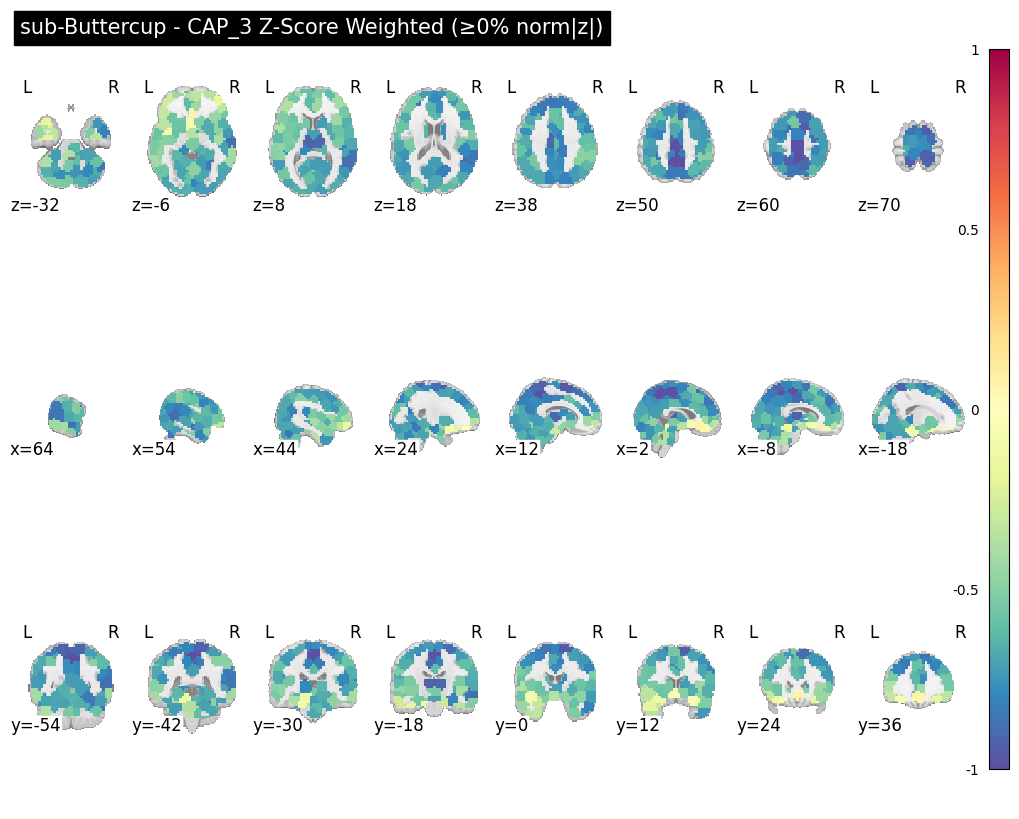

Saved positive weights: dset/derivatives/caps/caps_masks/sub-Buttercup_zscore-weighted-0_CAP_3_pos.nii.gz
Saved negative weights: dset/derivatives/caps/caps_masks/sub-Buttercup_zscore-weighted-0_CAP_3_neg.nii.gz


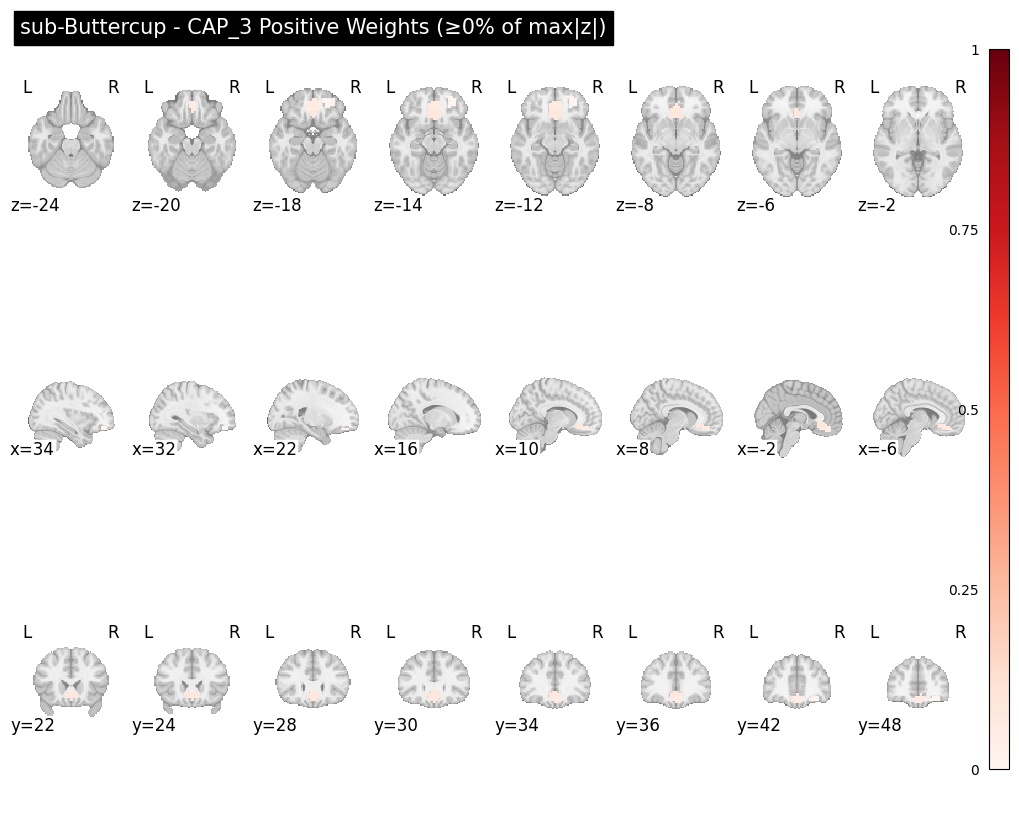

  Positive norm range: [0.006, 0.082]


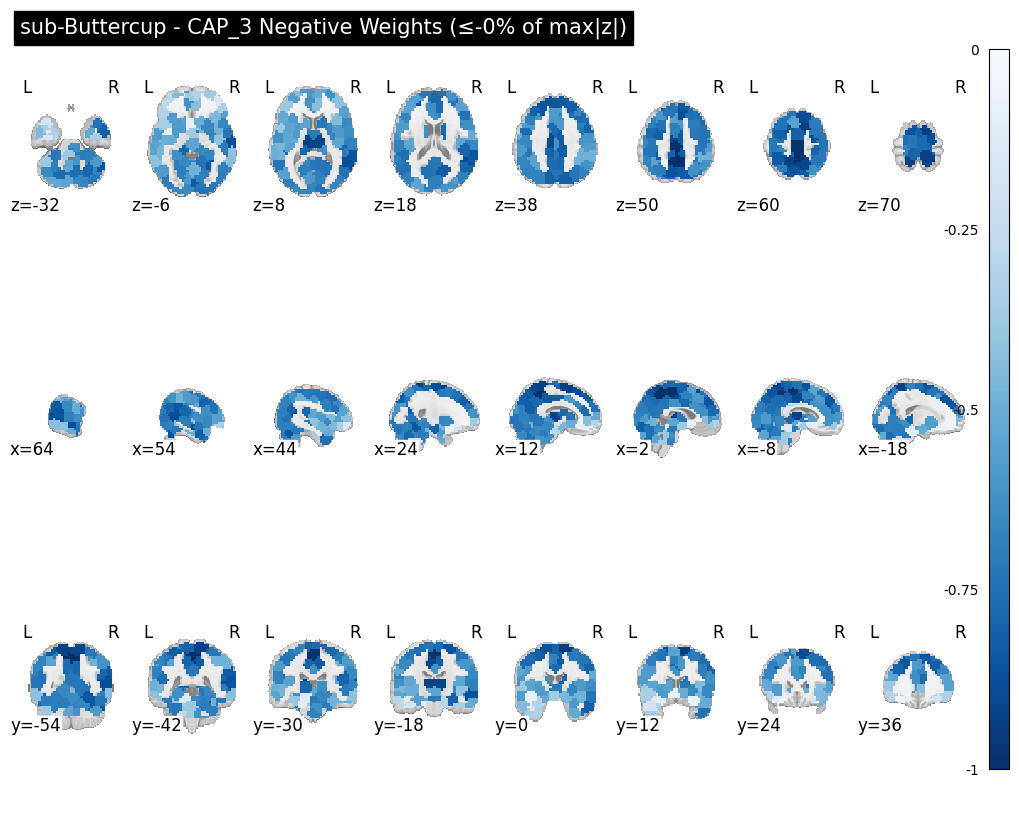

Saved z-score weighted NIfTI: dset/derivatives/caps/caps_masks/sub-Buttercup_zscore-weighted-0_CAP_4.nii.gz
  Original range:    [-0.064, 0.213]
  Normalized (kept): [-0.301, 1.000]


/var/folders/w7/tr80j6dx7kz1xqvddnxtqtzr0000gn/T/ipykernel_10132/2979503926.py:44: UserWarning: Attention: At least one of the (sub)peaks falls outside of the cluster body. Identifying the nearest in-cluster voxel.
  clusters = get_clusters_table(mask_img, thr_norm, two_sided=True)


Significant clusters:
   Cluster ID     X     Y     Z  Peak Stat Cluster Size (mm3)
0           1  50.0 -48.0 -22.0   1.000000            1116736
1          1a  60.0 -18.0  -8.0   0.991767                   
2          1b  62.0   0.0 -14.0   0.917442                   
3          1c  52.0 -34.0  -2.0   0.873735                   
4           2 -10.0  26.0  28.0   0.272323                 64
5           1 -10.0 -36.0 -14.0  -0.300966               4864
6           2 -26.0  48.0 -12.0  -0.188251              10048
7          2a -26.0  30.0 -16.0  -0.149101                   
8          2b -30.0  24.0   4.0  -0.031632                   
9           3  26.0  48.0 -16.0  -0.168103               1856
10          4 -54.0 -10.0  32.0  -0.148996               9664
11         4a -42.0 -18.0  44.0  -0.062599                   
12          5 -42.0  38.0   6.0  -0.088828               7680
13         5a -44.0  36.0  20.0  -0.013133                   
14          6 -38.0 -28.0  12.0  -0.085163      

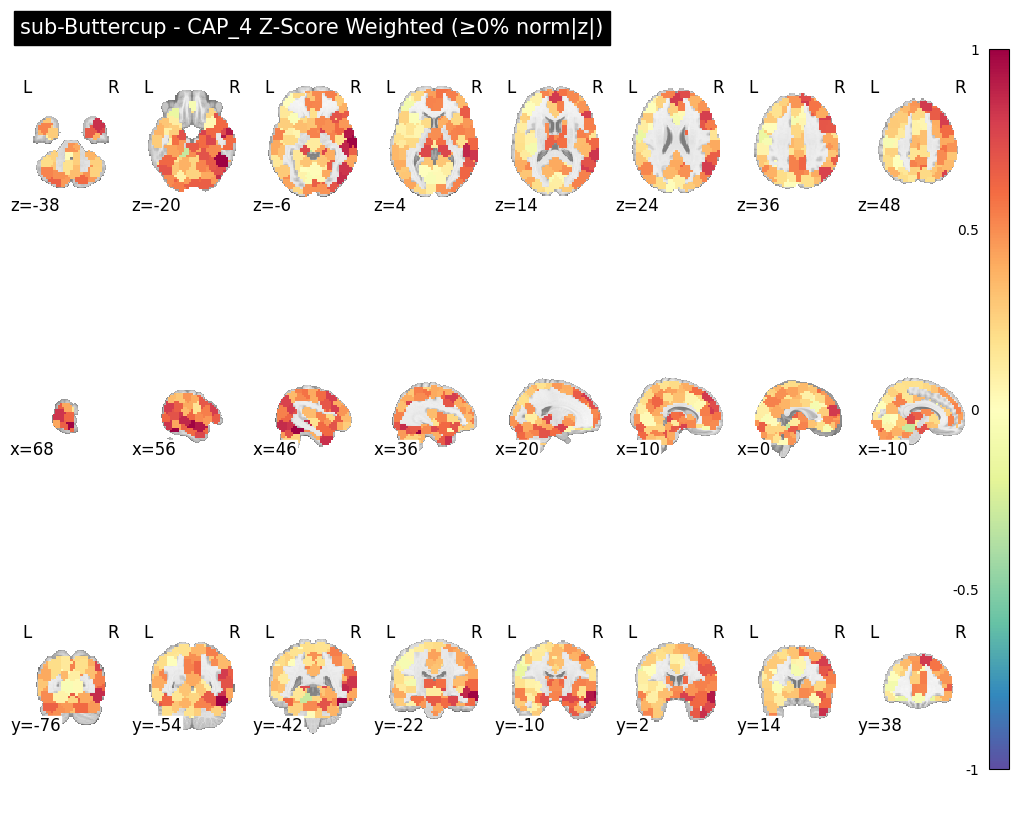

Saved positive weights: dset/derivatives/caps/caps_masks/sub-Buttercup_zscore-weighted-0_CAP_4_pos.nii.gz
Saved negative weights: dset/derivatives/caps/caps_masks/sub-Buttercup_zscore-weighted-0_CAP_4_neg.nii.gz


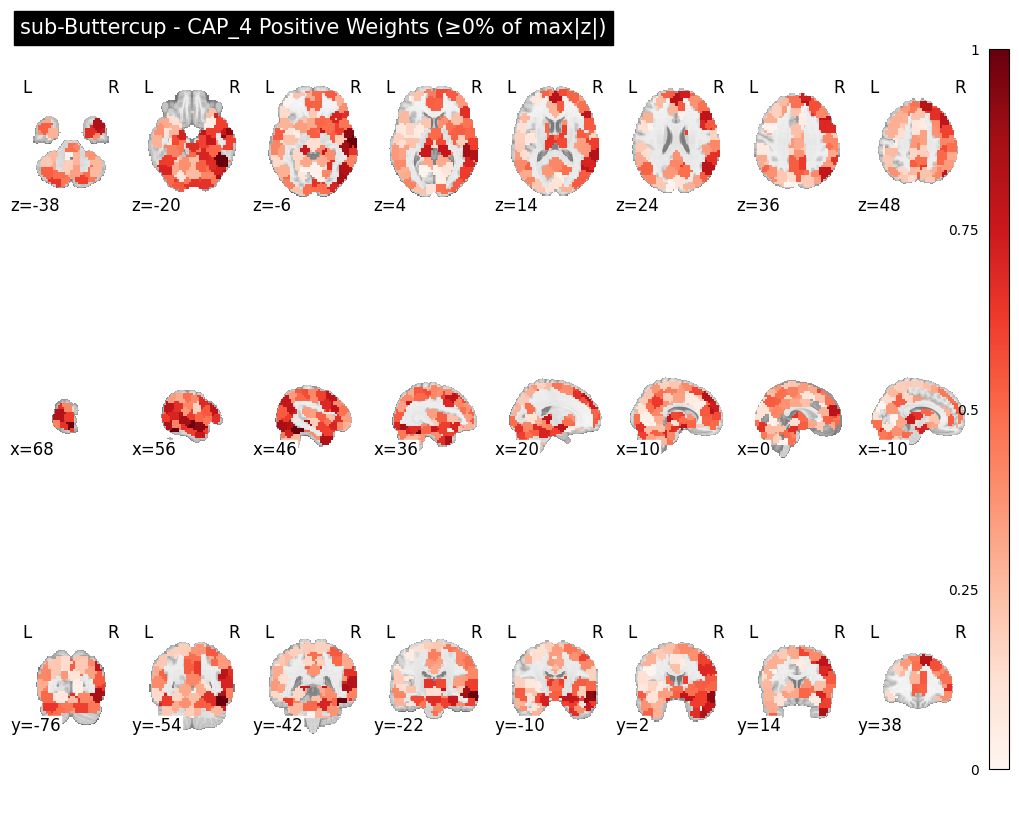

  Positive norm range: [0.004, 1.000]


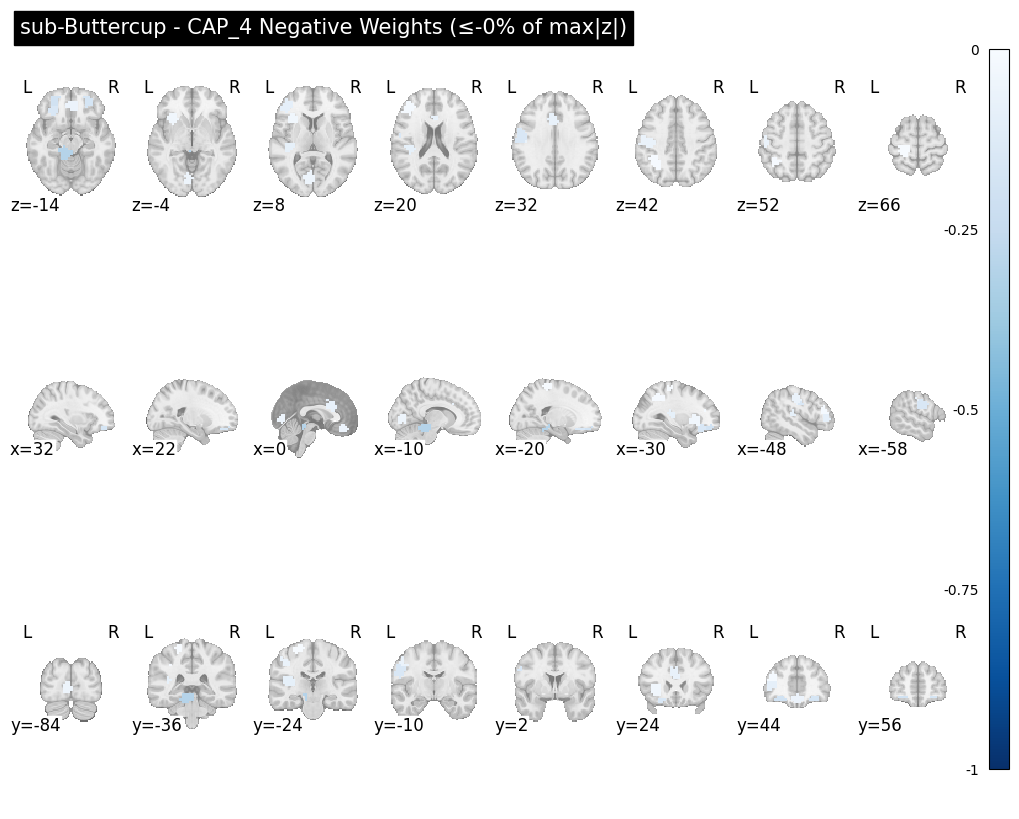

In [10]:
PCT_OF_MAX = 0.0  # keep |z| >= (PCT_OF_MAX/100) * max|z| per CAP

for sub_id, episodes in participant_data.items():
    print(f"\n{'='*60}\nPREPARING Z-SCORE NORMALIZED WEIGHTED MASKS FOR {sub_id}\n{'='*60}")

    centers_df = pd.read_csv(OUT_DIR / f"kmeans/{sub_id}_cluster_centers.csv")

    for i, cap in centers_df.iterrows():
        cap_df = pd.DataFrame([cap], columns=centers_df.columns)
        cap_name = cap_df.iloc[0, 0]
        roi_labels = [float(c) for c in cap_df.columns[1:]]
        z_vals = cap_df.iloc[0, 1:].astype(float).values

        # --- Z-score normalize to [-1, 1] using max |activation| ---
        vabs_full = float(np.nanmax(np.abs(z_vals)))
        if vabs_full == 0 or not np.isfinite(vabs_full):
            print(f"Skipping {sub_id} {cap_name}: max|z| is zero or NaN.")
            continue
        z_vals_norm = z_vals / vabs_full  # Now in [-1, 1]
        
        # --- Apply threshold on normalized values ---
        thr_norm = PCT_OF_MAX / 100.0  # e.g., 0.15 for 15%
        z_vals_thresh = np.where(np.abs(z_vals_norm) >= thr_norm, z_vals_norm, 0.0)

        # --- Map normalized & thresholded values to atlas (stay in [-1, 1]) ---
        atlas_data = np.asanyarray(atlas_img.dataobj)
        mask_data = np.zeros_like(atlas_data, dtype=np.float32)
        for roi, z_norm in zip(roi_labels, z_vals_thresh):
            if np.isfinite(z_norm) and z_norm != 0.0:
                mask_data[atlas_data == int(roi)] = z_norm  # values in [-1, 1]

        # --- Save z-score normalized weighted CAP (values in [-1, 1]) ---
        mask_img = nib.Nifti1Image(mask_data, atlas_img.affine, atlas_img.header)
        mask_path = MASK_DIR / f"{sub_id}_zscore-weighted-{int(PCT_OF_MAX)}_{cap_name}.nii.gz"
        nib.save(mask_img, mask_path)
        print(f"Saved z-score weighted NIfTI: {mask_path}")
        print(f"  Original range:    [{np.min(z_vals):.3f}, {np.max(z_vals):.3f}]")
        nonzero = mask_data[mask_data != 0]
        if nonzero.size:
            print(f"  Normalized (kept): [{np.min(nonzero):.3f}, {np.max(nonzero):.3f}]")
        else:
            print("  Normalized (kept): [empty after threshold]")

        clusters = get_clusters_table(mask_img, thr_norm, two_sided=True)
        print("Significant clusters:")
        print(clusters)

        # --- Plot full (symmetric) normalized map in [-1, 1] ---
        fig = plt.figure(figsize=(10, 8))
        plotting.plot_stat_map(
            mask_img,
            title=f"{sub_id} - {cap_name} Z-Score Weighted (≥{int(PCT_OF_MAX)}% norm|z|)",
            display_mode="mosaic",
            cut_coords=8,
            cmap="Spectral_r",
            colorbar=True,
            threshold=thr_norm,   # threshold in normalized units
            symmetric_cbar=True,
            vmin=-1.0,
            vmax=1.0,
            figure=fig
        )
        plt.show()

        # --- Split into positive and negative parts ---
        pos_data = np.where(mask_data > 0, mask_data, 0.0)
        neg_data = np.where(mask_data < 0, mask_data, 0.0)

        pos_img = nib.Nifti1Image(pos_data, atlas_img.affine, atlas_img.header)
        neg_img = nib.Nifti1Image(neg_data, atlas_img.affine, atlas_img.header)

        # Save separate positive and negative weighted maps (still in [-1, 1])
        pos_path = MASK_DIR / f"{sub_id}_zscore-weighted-{int(PCT_OF_MAX)}_{cap_name}_pos.nii.gz"
        neg_path = MASK_DIR / f"{sub_id}_zscore-weighted-{int(PCT_OF_MAX)}_{cap_name}_neg.nii.gz"
        nib.save(pos_img, pos_path)
        nib.save(neg_img, neg_path)
        print(f"Saved positive weights: {pos_path}")
        print(f"Saved negative weights: {neg_path}")

        # --- Plot positive weights only (0 → 1) ---
        pos_vals = pos_data[pos_data > 0]
        if pos_vals.size:
            fig = plt.figure(figsize=(10, 8))
            plotting.plot_stat_map(
                pos_img,
                title=f"{sub_id} - {cap_name} Positive Weights (≥{int(PCT_OF_MAX)}% of max|z|)",
                display_mode="mosaic",
                cut_coords=8,
                cmap="Reds",
                colorbar=True,
                threshold=thr_norm,  # normalized threshold
                vmin=0.0,
                vmax=1.0,
                figure=fig
            )
            plt.show()
            print(f"  Positive norm range: [{np.min(pos_vals):.3f}, {np.max(pos_vals):.3f}]")
        else:
            print(f"No positive activations for {cap_name}")

        # --- Plot negative weights only (-1 → 0) ---
        neg_vals = neg_data[neg_data < 0]
        if neg_vals.size:
            fig = plt.figure(figsize=(10, 8))
            plotting.plot_stat_map(
                neg_img,
                title=f"{sub_id} - {cap_name} Negative Weights (≤-{int(PCT_OF_MAX)}% of max|z|)",
                display_mode="mosaic",
                cut_coords=8,
                cmap="Blues_r",
                colorbar=True,
                threshold=thr_norm,  # must be non-negative
                vmin=-1.0,
                vmax=0.0,
                symmetric_cbar=False,
                figure=fig
            )
            plt.show()

    print("")


CREATING DOT PLOTS FOR sub-Blossom

Creating dot plot for sub-Blossom with 4 CAPs...


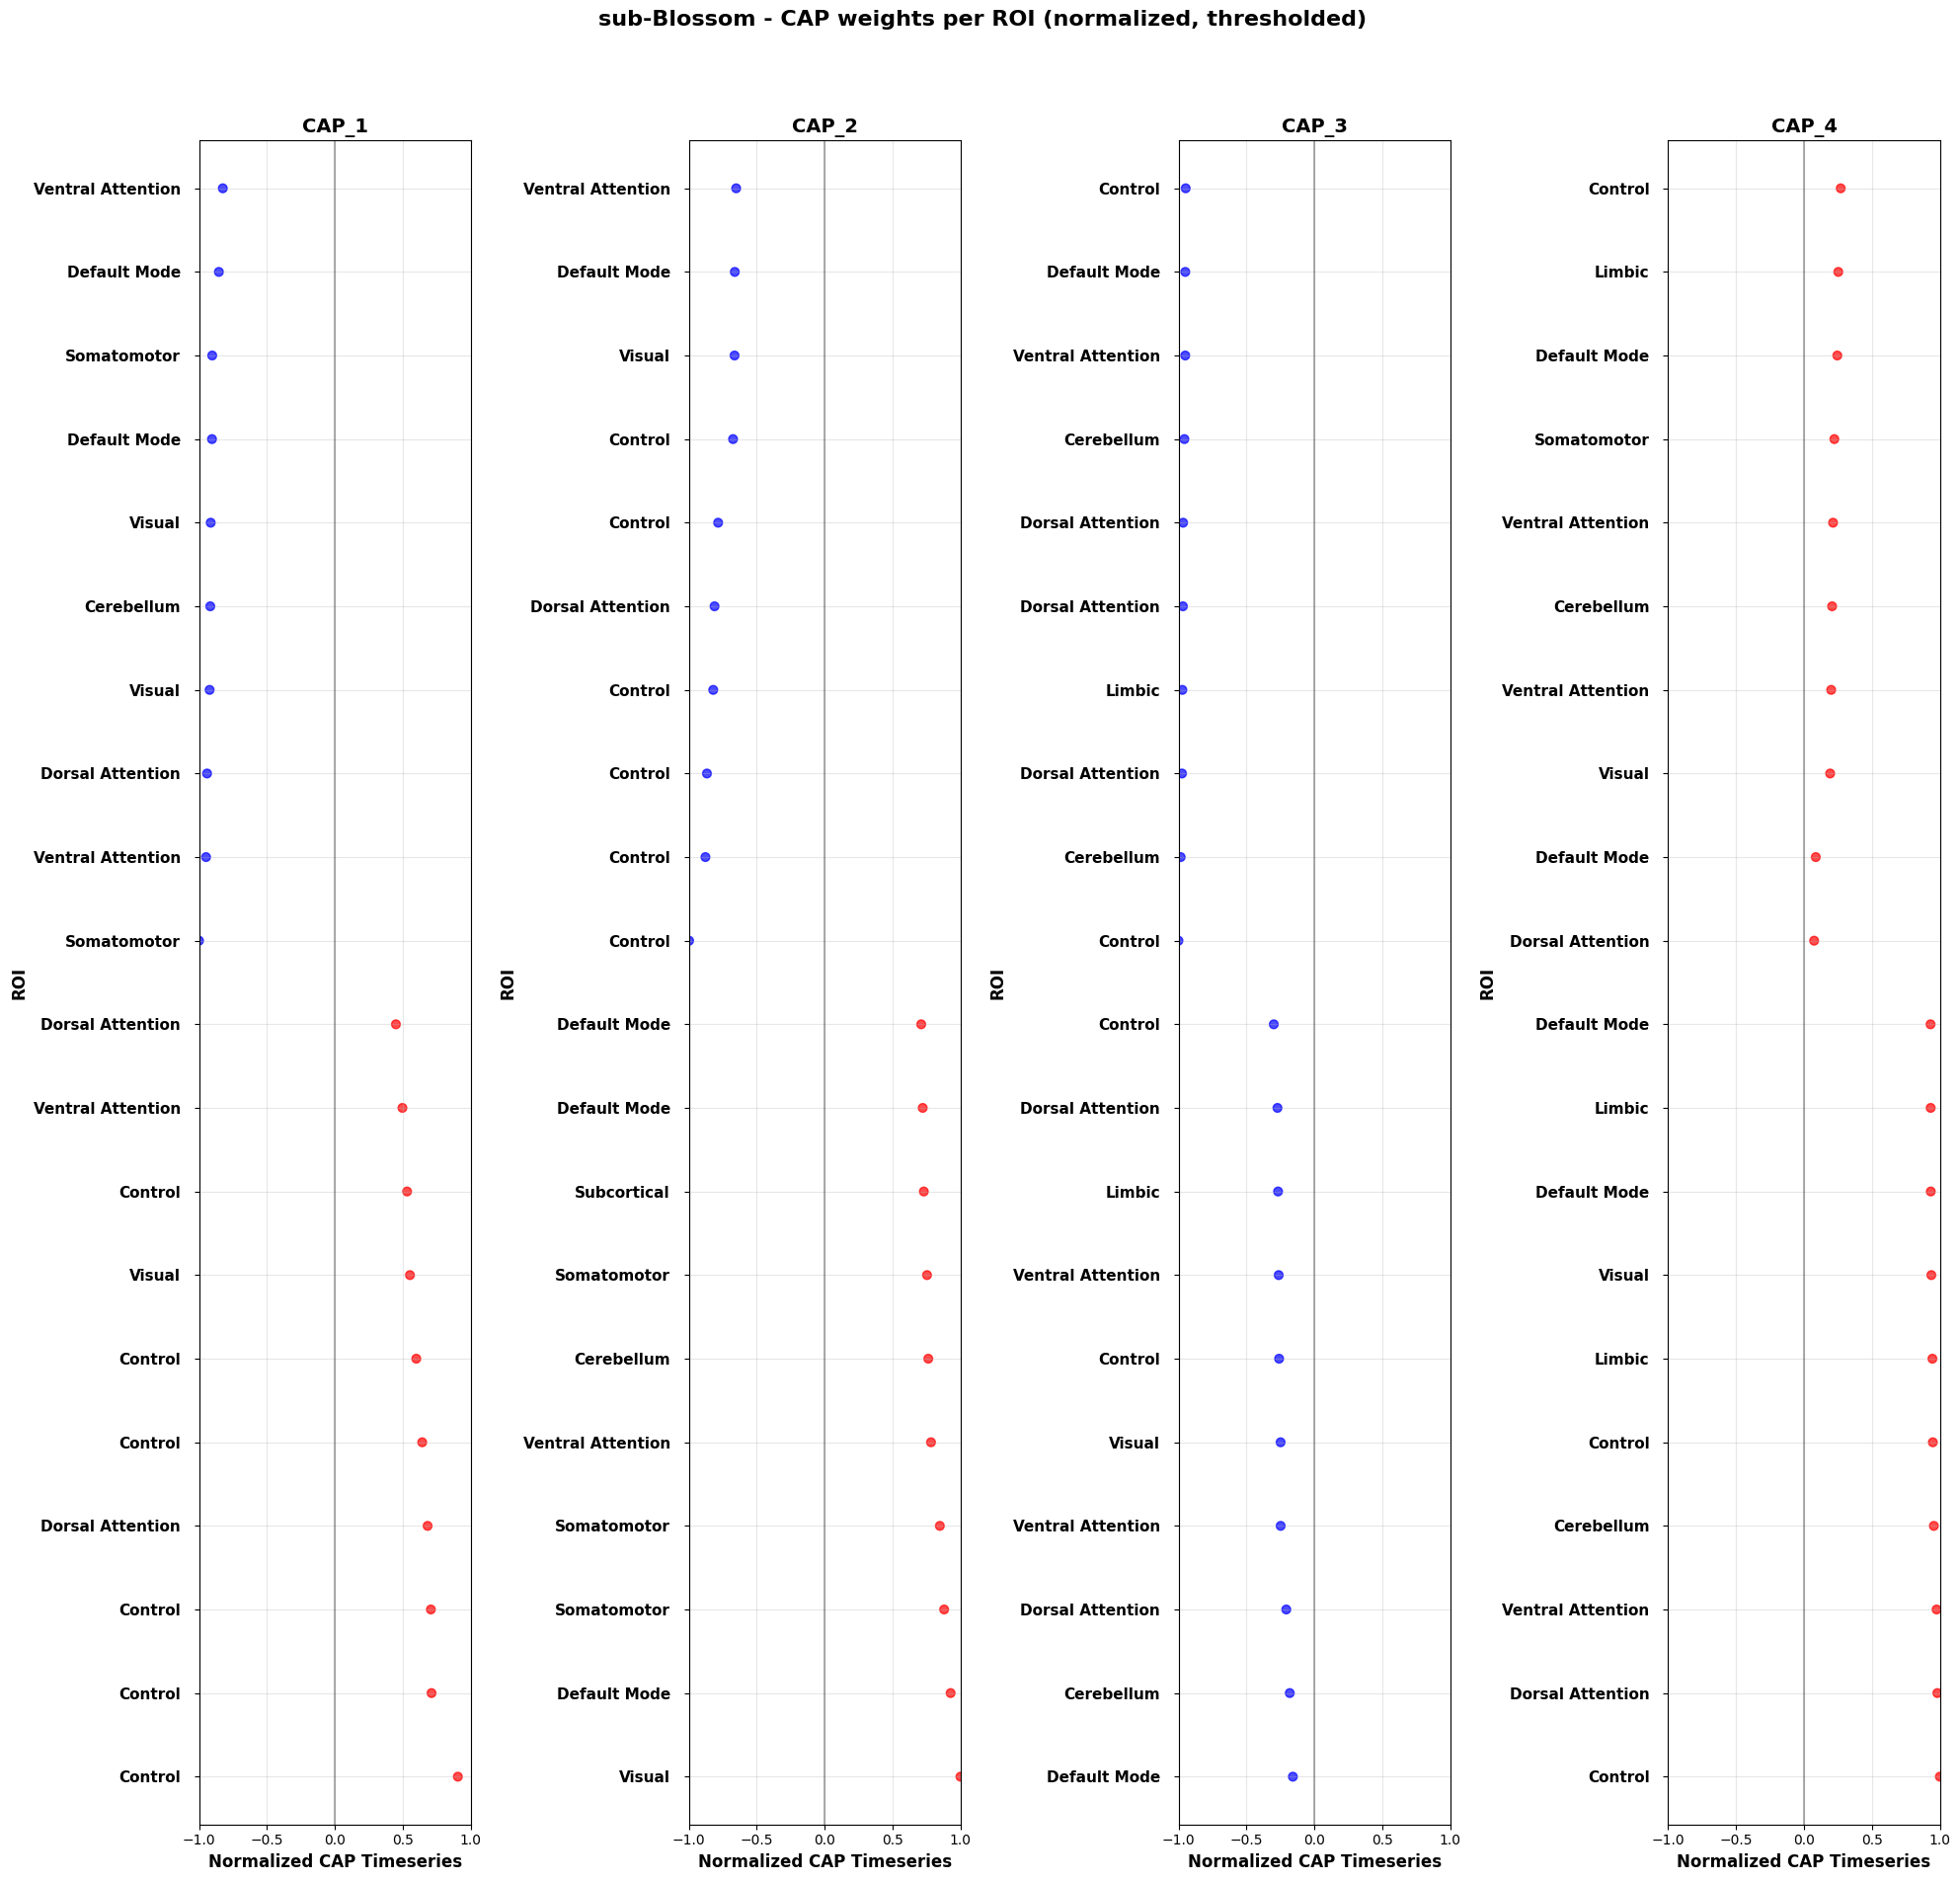



CREATING DOT PLOTS FOR sub-Bubbles

Creating dot plot for sub-Bubbles with 5 CAPs...


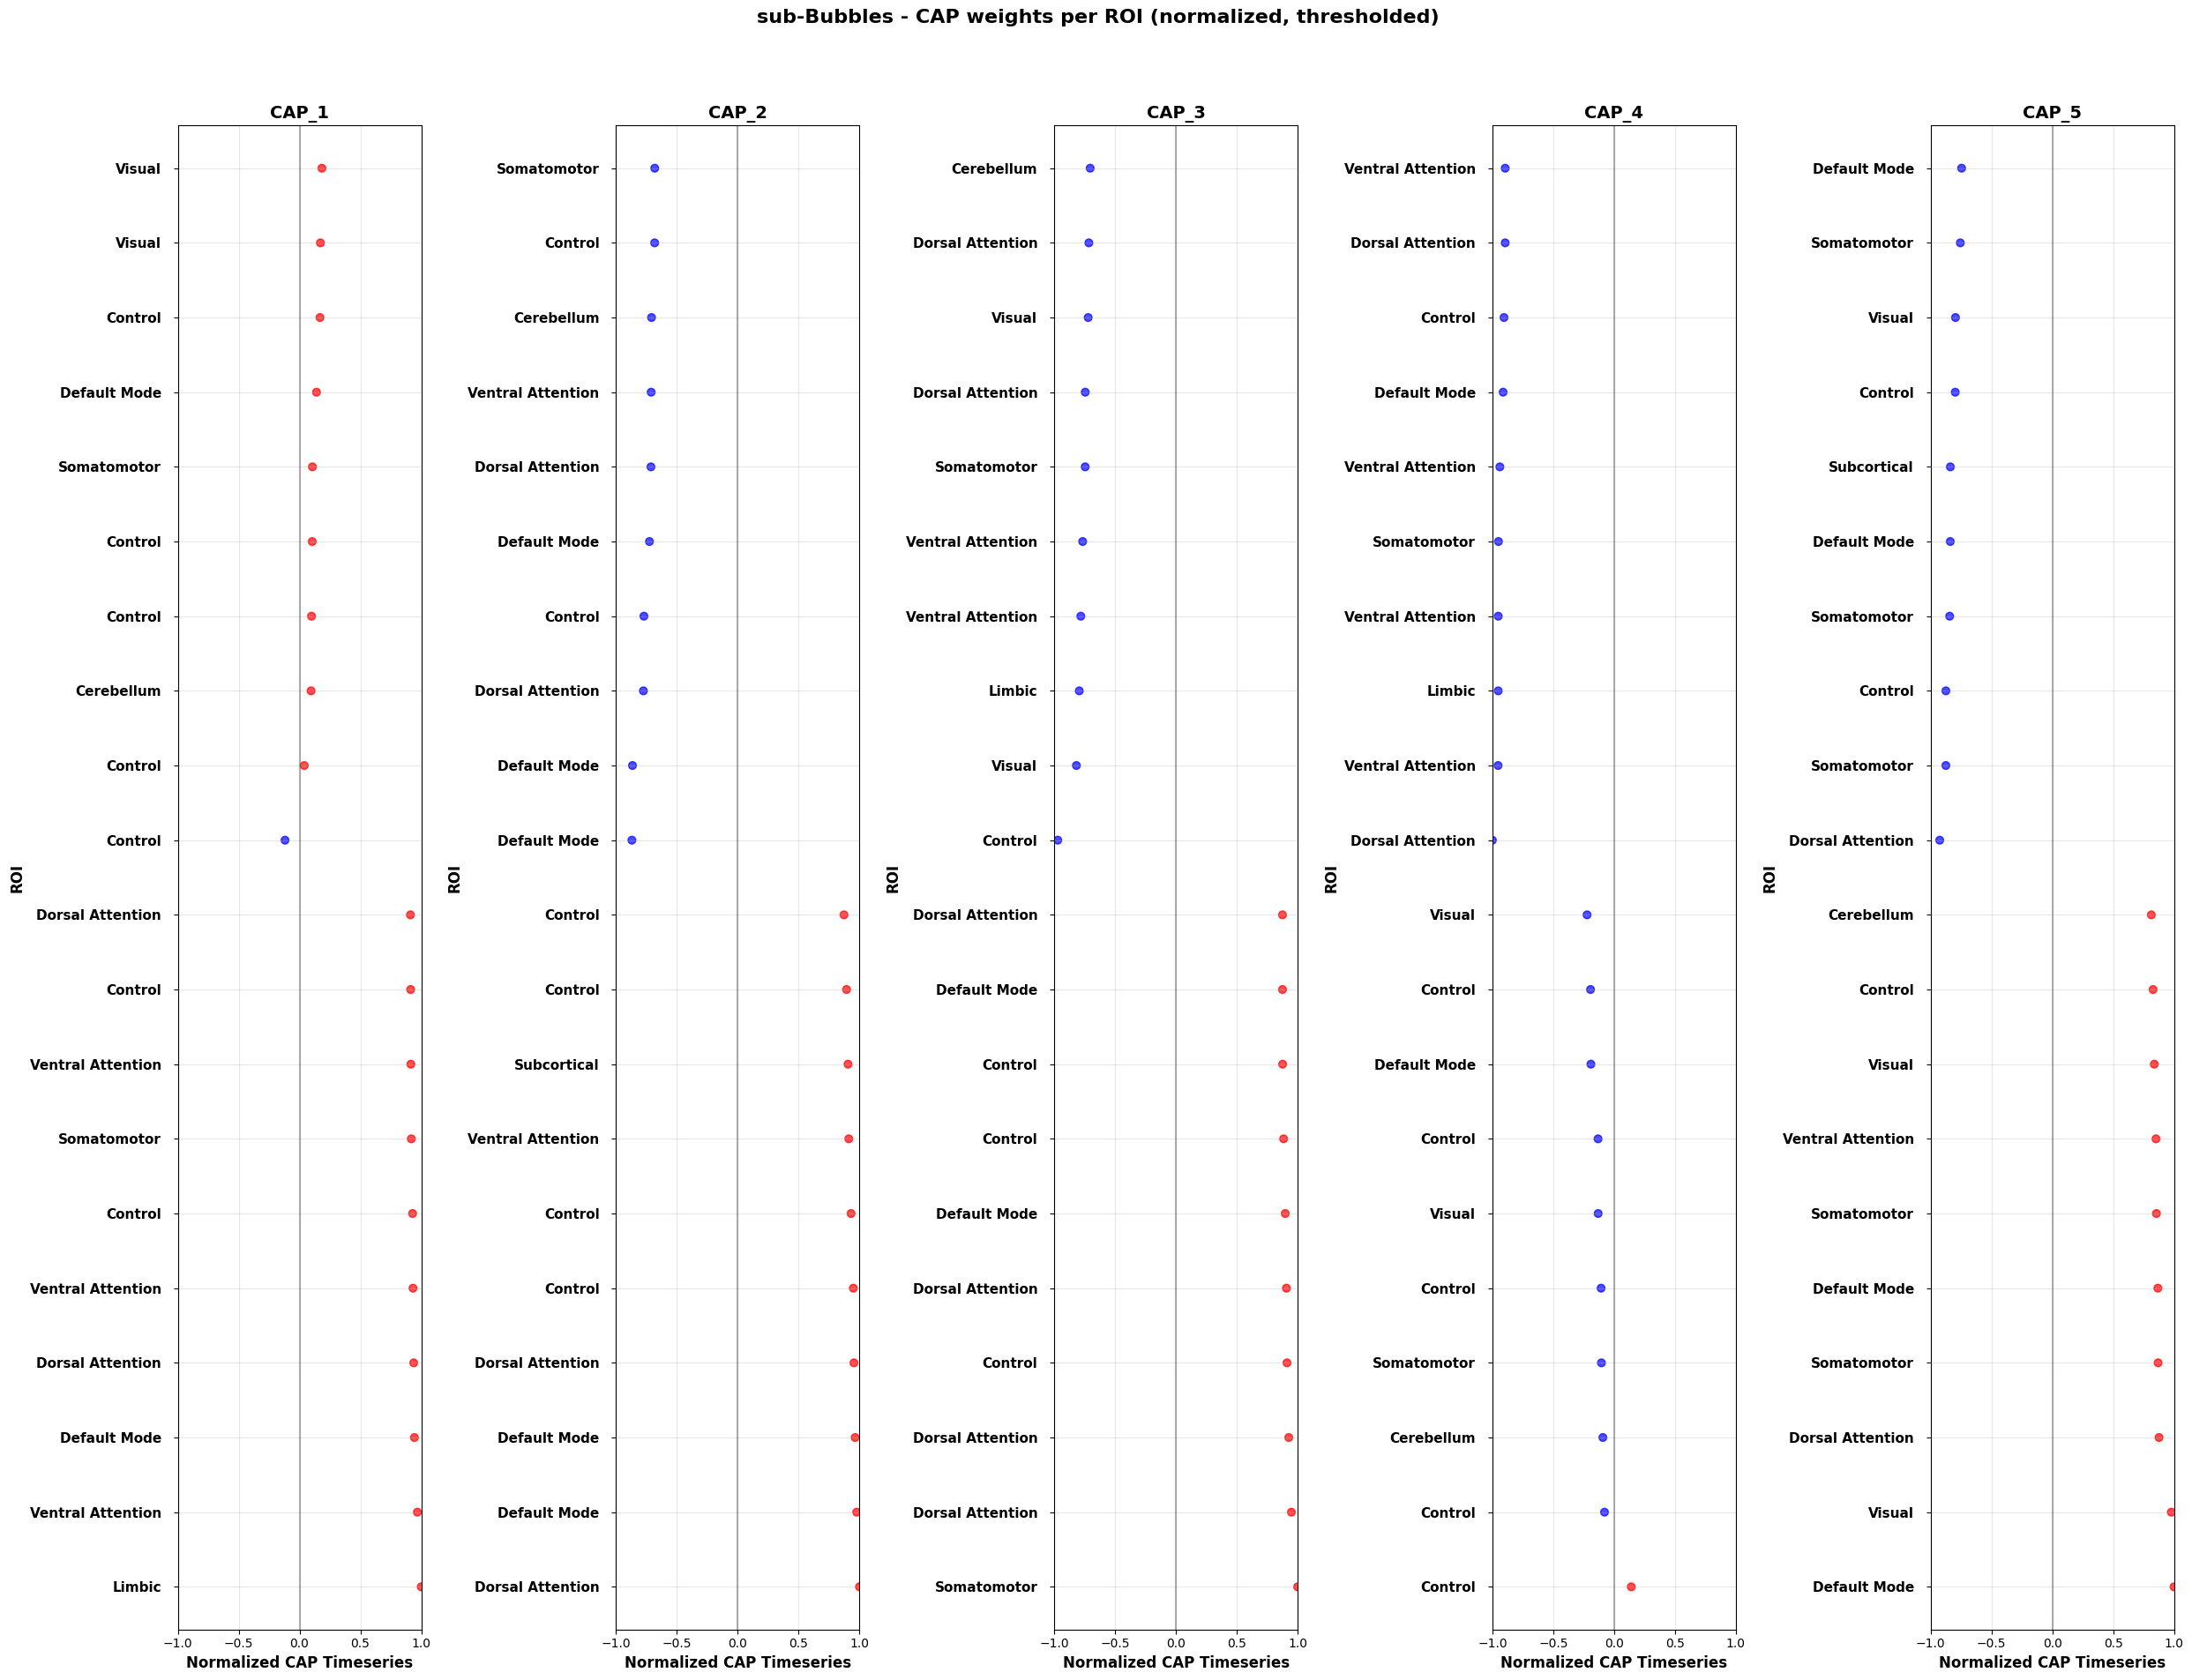



CREATING DOT PLOTS FOR sub-Buttercup

Creating dot plot for sub-Buttercup with 4 CAPs...


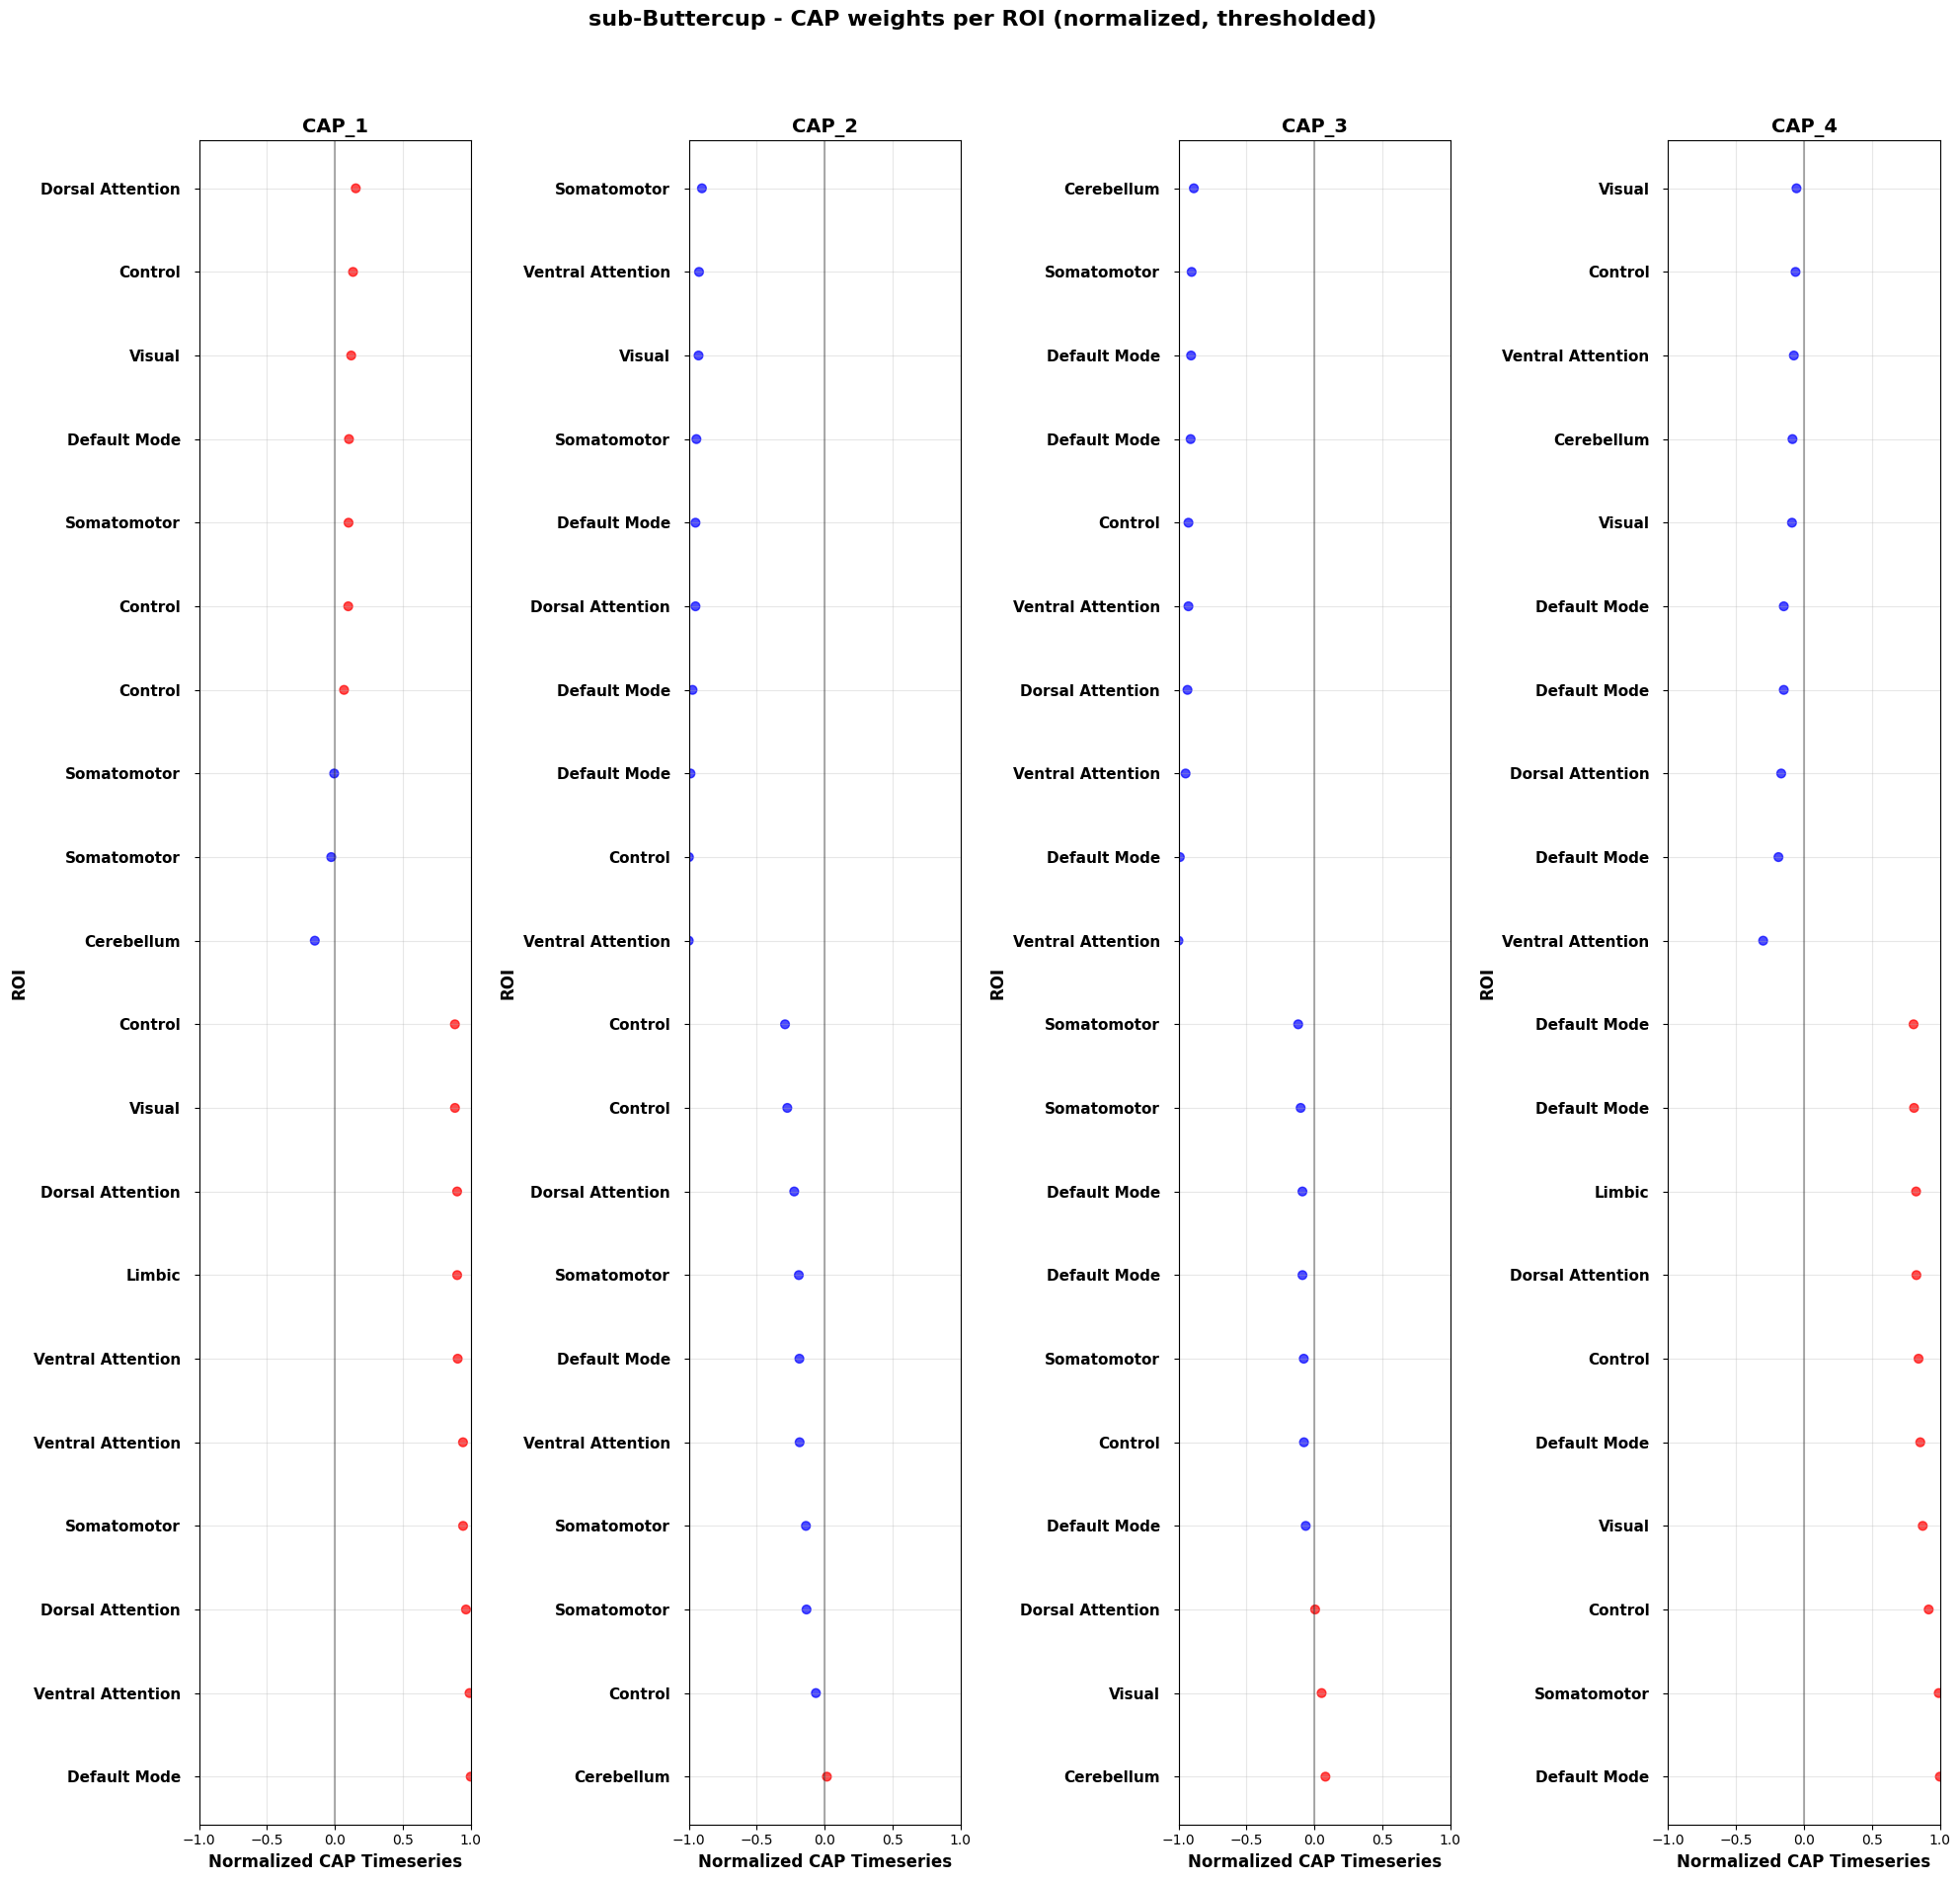

In [ ]:
# Load the ROI names (ROI_Number, Network_Label)
roi_path = Path("dset/craddock270_network_labels.csv")
roi_df = pd.read_csv(roi_path).sort_values("ROI_Number")
roi_name_list = roi_df["Network_Label"].tolist()   # <--- USE THESE

PCT_OF_MAX = 0.0  # keep |z| >= (PCT_OF_MAX/100) * max|z| per CAP

for sub_id, episodes in participant_data.items():
    print(f"\n{'='*60}\nCREATING DOT PLOTS FOR {sub_id}\n{'='*60}")

    centers_df = pd.read_csv(OUT_DIR / f"kmeans/{sub_id}_cluster_centers.csv")
    cap_names_list = []
    cap_weights_list = []  # each entry: array of length n_rois (normalized, thresholded)

    for i, cap in centers_df.iterrows():
        cap_df = pd.DataFrame([cap], columns=centers_df.columns)
        cap_name = cap_df.iloc[0, 0]
        z_vals = cap_df.iloc[0, 1:].astype(float).values

        # --- Z-score normalize to [-1, 1] using max |activation| ---
        vabs_full = float(np.nanmax(np.abs(z_vals)))
        if vabs_full == 0 or not np.isfinite(vabs_full):
            print(f"Skipping {sub_id} {cap_name}: max|z| is zero or NaN.")
            continue
        z_vals_norm = z_vals / vabs_full  # Now in [-1, 1]
        
        # --- Apply threshold on normalized values ---
        thr_norm = PCT_OF_MAX / 100.0
        z_vals_thresh = np.where(np.abs(z_vals_norm) >= thr_norm, z_vals_norm, 0.0)

        cap_names_list.append(cap_name)
        cap_weights_list.append(z_vals_thresh)
    
    # --- Create dot plot for all CAPs at the end of each participant ---
    if cap_names_list and cap_weights_list:
        print(f"\nCreating dot plot for {sub_id} with {len(cap_names_list)} CAPs...")
        
        # shape: (n_rois, n_caps)
        weights_mat = np.vstack(cap_weights_list).T

        # NEW: use network labels instead of integer ROI labels
        roi_labels_named = roi_name_list

        n_caps = len(cap_names_list)
        fig, axes = plt.subplots(1, n_caps, figsize=(5*n_caps, 20), sharey=False)
        
        if n_caps == 1:
            axes = [axes]
        
        for i, (cap_name, cap_weights) in enumerate(zip(cap_names_list, cap_weights_list)):
            ax = axes[i]
            
            # Get all values with their indices and names
            all_indices = np.arange(len(cap_weights))
            all_values = cap_weights
            all_names = [roi_labels_named[idx] for idx in all_indices]
            
            # Sort by values (highest to lowest)
            sort_indices = np.argsort(all_values)[::-1]
            sorted_values = all_values[sort_indices]
            sorted_names = [all_names[idx] for idx in sort_indices]
            
            # Get top 10 highest (positive weights)
            top_10_values = sorted_values[:10]
            top_10_names = sorted_names[:10]
            
            # Get bottom 10 lowest (negative weights) - reverse order so most negative is at bottom
            bottom_10_values = sorted_values[-10:][::-1]
            bottom_10_names = sorted_names[-10:][::-1]
            
            # Combine: top 10 at top, bottom 10 at bottom
            selected_values = np.concatenate([top_10_values, bottom_10_values])
            selected_names = top_10_names + bottom_10_names
            
            if len(selected_values) > 0:
                y_positions = np.arange(len(selected_values)) * 3.5
                
                # Color code: positive = red, negative = blue
                colors = ['red' if v > 0 else 'blue' for v in selected_values]
                
                ax.scatter(selected_values, y_positions, alpha=0.7, s=40, c=colors)
                
                ax.set_yticks(y_positions)
                ax.set_yticklabels(
                    [f"{roi}" for roi in selected_names],
                    fontsize=12,
                    fontweight='bold'
                )
                ax.set_ylim(-2, y_positions[-1] + 2)
                
                ax.tick_params(axis='y', which='major', pad=10, labelsize=11)
            else:
                ax.set_yticks([])
                ax.set_ylim(-0.5, 0.5)
            
            ax.set_xlim(-1.0, 1.0)
            ax.set_xlabel('Normalized CAP Timeseries', fontsize=12, fontweight='bold')
            ax.set_ylabel('ROI', fontsize=12, fontweight='bold')
            ax.set_title(cap_name, fontsize=14, fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.axvline(x=0, color='black', linestyle='-', alpha=0.3)

        
        fig.suptitle(f"{sub_id} - CAP weights per ROI (normalized, thresholded)", fontsize=16, fontweight='bold')
        plt.tight_layout(rect=[0, 0.03, 0, 0.95], w_pad=1.0)
        plt.show()
    else:
        print(f"No valid CAPs to plot for {sub_id}")

    print("")
